<center>
    
## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
 
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [3]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [4]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition
from sklearn import metrics

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [5]:
df = df = pd.read_csv("./players_21.csv")
df.head(4)

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     200389  https://sofifa.com/player/200389/jan-oblak/210002   
3     188545  https://sofifa.com/player/188545/robert-lewand...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   33  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   35  1985-02-05   
2           J. Oblak                            Jan Oblak   27  1993-01-07   
3     R. Lewandowski                   Robert Lewandowski   31  1988-08-21   

   height_cm  weight_kg nationality          club_name  \
0        170         72   Argentina       FC Barcelona   
1        187         83    Portugal           Juventus   
2        188         87    Slovenia    Atlético Madrid   
3        184         80      Poland  FC Bayern München   

              league_name  league_rank  overall  potential  value_eur  \
0  Spain Primera Division          1.0       93         93   67500000   
1         Italian Serie A          1.0       92         92   46000000   
2  Spain Primera Division          1.0       91         93   75000000   
3    German 1. Bundesliga          1.0       91         91   80000000   

   wage_eur player_positions preferred_foot  international_reputation  \
0    560000       RW, ST, CF           Left                         5   
1    220000           ST, LW          Right                         5   
2    125000               GK          Right                         3   
3    240000               ST          Right                         4   

   weak_foot  skill_moves      work_rate             body_type real_face  \
0          4            4     Medium/Low                 Messi       Yes   
1          4            5       High/Low            C. Ronaldo       Yes   
2          3            1  Medium/Medium  PLAYER_BODY_TYPE_259       Yes   
3          4            4    High/Medium  PLAYER_BODY_TYPE_276       Yes   

   release_clause_eur                                        player_tags  \
0         138400000.0  #Dribbler, #Distance Shooter, #FK Specialist, ...   
1          75900000.0  #Aerial Threat, #Dribbler, #Distance Shooter, ...   
2         159400000.0                                                NaN   
3         132000000.0              #Distance Shooter, #Clinical Finisher   

  team_position  team_jersey_number loaned_from      joined  \
0           CAM                10.0         NaN  2004-07-01   
1            LS                 7.0         NaN  2018-07-10   
2            GK                13.0         NaN  2014-07-16   
3            ST                 9.0         NaN  2014-07-01   

   contract_valid_until nation_position  nation_jersey_number  pace  shooting  \
0                2021.0              RW                  10.0  85.0      92.0   
1                2022.0              LS                   7.0  89.0      93.0   
2                2023.0              GK                   1.0   NaN       NaN   
3                2023.0             NaN                   NaN  78.0      91.0   

   passing  dribbling  defending  physic  gk_diving  gk_handling  gk_kicking  \
0     91.0       95.0       38.0    65.0        NaN          NaN         NaN   
1     81.0       89.0       35.0    77.0        NaN          NaN         NaN   
2      NaN        NaN        NaN     NaN       87.0         92.0        78.0   
3     78.0       85.0       43.0    82.0        NaN          NaN         NaN   

   gk_reflexes  gk_speed  gk_positioning  \
0          NaN       NaN             NaN   
1          NaN       NaN             NaN   
2         90.0      52.0            90.0   
3          NaN       NaN             NaN   

                                       player_traits  attacking_crossing  \
0  Finesse Shot, Long Shot Taker (AI), Speed Drib...                  8

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18944 entries, 0 to 18943
Columns: 106 entries, sofifa_id to rb
dtypes: float64(18), int64(44), object(44)
memory usage: 15.3+ MB


**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [7]:
# A diferencia del dataset usado en clase del fifa 2019, en este cada jugador puede tener asignada mas de una posicion
# Por eso para realizar el conteo de las posiciones tomamos la primera de las posiciones asignada a cada jugador
df['first_position'] = df['player_positions'].apply(lambda x: x.split(', ')[0])

In [8]:
n=10000
df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['overall']>70)] # mejores jugadores

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 
                  'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
                  'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
                  'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 
                  'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
                  'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving',
                  'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']


print(len(skills_ratings), 'variables numéricas: skills/habilidades')

df_skills=df_n[skills_ratings]

34 variables numéricas: skills/habilidades


In [9]:
df_skills.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4512 entries, 0 to 4511
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   attacking_crossing          4512 non-null   int64  
 1   attacking_finishing         4512 non-null   int64  
 2   attacking_heading_accuracy  4512 non-null   int64  
 3   attacking_short_passing     4512 non-null   int64  
 4   attacking_volleys           4512 non-null   int64  
 5   skill_dribbling             4512 non-null   int64  
 6   skill_curve                 4512 non-null   int64  
 7   skill_fk_accuracy           4512 non-null   int64  
 8   skill_long_passing          4512 non-null   int64  
 9   skill_ball_control          4512 non-null   int64  
 10  movement_acceleration       4512 non-null   int64  
 11  movement_sprint_speed       4512 non-null   int64  
 12  movement_agility            4512 non-null   int64  
 13  movement_reactions          4512 

In [10]:
# esta variable se va a eliminar por tener valores nulos
df_skills['defending_marking'] 

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4507   NaN
4508   NaN
4509   NaN
4510   NaN
4511   NaN
Name: defending_marking, Length: 4512, dtype: float64

In [11]:
df_skills=df_skills.drop(["defending_marking"], axis=1)

In [12]:
df_skills.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4512 entries, 0 to 4511
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   attacking_crossing          4512 non-null   int64
 1   attacking_finishing         4512 non-null   int64
 2   attacking_heading_accuracy  4512 non-null   int64
 3   attacking_short_passing     4512 non-null   int64
 4   attacking_volleys           4512 non-null   int64
 5   skill_dribbling             4512 non-null   int64
 6   skill_curve                 4512 non-null   int64
 7   skill_fk_accuracy           4512 non-null   int64
 8   skill_long_passing          4512 non-null   int64
 9   skill_ball_control          4512 non-null   int64
 10  movement_acceleration       4512 non-null   int64
 11  movement_sprint_speed       4512 non-null   int64
 12  movement_agility            4512 non-null   int64
 13  movement_reactions          4512 non-null   int64
 14  movement

# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

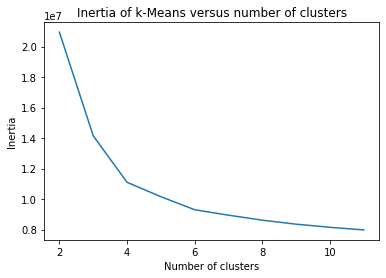

In [13]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [14]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  11098843.81533827


**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [15]:
df_skills_pos = df_n[skills_ratings + ['first_position']]

In [16]:
dict_pos = {'CB':'Defensor', 'RB':'Defensor', 'LB':'Defensor', 'RWB':'Defensor', 'LWB':'Defensor',
        'CM':'Mediocampo', 'CDM':'Mediocampo', 'CAM':'Mediocampo', 'RM':'Mediocampo', 'LM':'Mediocampo', 
        'ST':'Delantero', 'CF':'Delantero', 'RF':'Delantero', 'LF':'Delantero', 'RW':'Delantero', 'LW': 'Delantero',
        'GK':'Arquero'}
df_skills_pos['type_position'] = df_skills_pos['first_position'].replace(dict_pos)

In [17]:
df_skills_pos["cluster"] = clusters

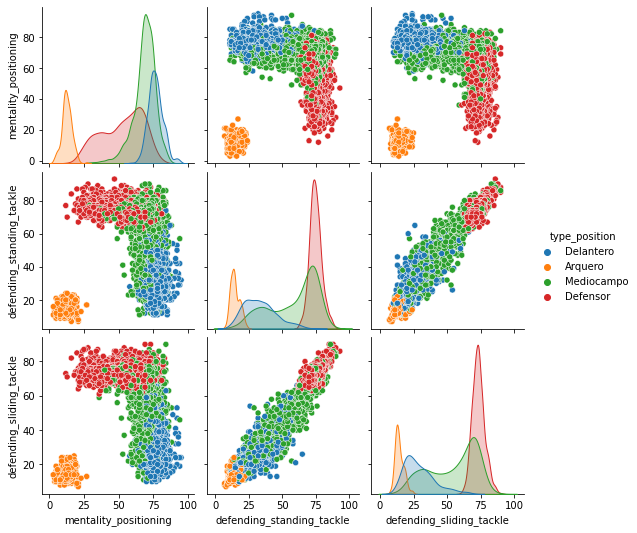

In [18]:
sns.pairplot(data=df_skills_pos, hue='type_position', 
             vars=['mentality_positioning', 'defending_standing_tackle', 'defending_sliding_tackle'])

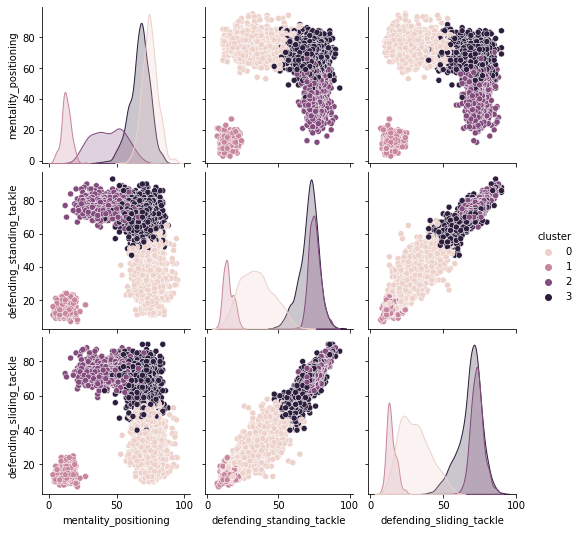

In [19]:
sns.pairplot(data=df_skills_pos, hue='cluster', 
             vars=['mentality_positioning', 'defending_standing_tackle', 'defending_sliding_tackle'])

Si comparamos agrupamiento realizado por kmeans y lo agrupado manualmente se observa que  los arqueros y los defesonres se  agruparon de manera correcta,para el resto de las posiciones no fue tan acertado.


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 

- Cantidad de observaciones por Cluster

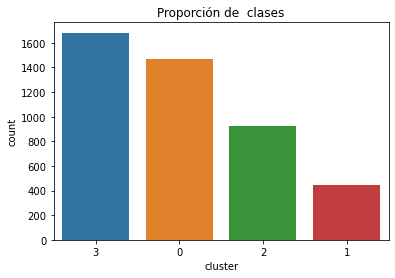

3    1682
0    1465
2     921
1     444
Name: cluster, dtype: int64

In [20]:
sns.countplot(df_skills_pos.cluster, order=df_skills_pos.cluster.value_counts().index)
plt.title("Proporción de  clases")
plt.show()
df_skills_pos["cluster"].value_counts()

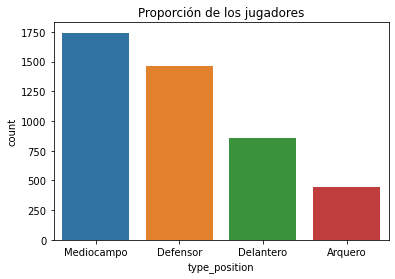

Mediocampo    1743
Defensor      1467
Delantero      858
Arquero        444
Name: type_position, dtype: int64

In [21]:
sns.countplot(df_skills_pos.type_position, order=df_skills_pos.type_position.value_counts().index)
plt.title("Proporción de los jugadores")
plt.show()
df_skills_pos["type_position"].value_counts()

En los graficos se observa, la distribucion de los cluster, de los cuales para la posicion de los arqueros y defensores se logro conseguir un gran acierto.

- Análisis descriptivo separando por Cluster

In [22]:
df_cluster_0=df_skills_pos[df_skills_pos["cluster"]==0]
df_cluster_1=df_skills_pos[df_skills_pos["cluster"]==1]
df_cluster_2=df_skills_pos[df_skills_pos["cluster"]==2]
df_cluster_3=df_skills_pos[df_skills_pos["cluster"]==3]

In [23]:
df_cluster_0.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1465.000000          1465.000000                 1465.000000   
mean            65.591809            72.713993                   60.918089   
std             10.915407             6.393792                   14.234141   
min             23.000000            51.000000                   20.000000   
25%             61.000000            68.000000                   49.000000   
50%             68.000000            73.000000                   62.000000   
75%             73.000000            77.000000                   73.000000   
max             92.000000            95.000000                   93.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1465.000000        1465.000000      1465.000000   
mean                 71.536519          67.350171        75.868259   
std                   5.658321           8.695571         5.866780   
min                  53.000000          32.000000        57.000000   
25%                  68.000000          62.000000        72.000000   
50%                  72.000000          68.000000        76.000000   
75%                  75.000000          74.000000        80.000000   
max                  92.000000          90.000000        96.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1465.000000        1465.000000         1465.000000         1465.000000   
mean     67.954266          60.627986           61.805461           75.813652   
std      10.612973          13.712511           10.386570            4.978652   
min      26.000000          22.000000           25.000000           57.000000   
25%      62.000000          51.000000           56.000000           73.000000   
50%      69.000000          63.000000           63.000000           75.000000   
75%      75.000000          71.000000           69.000000           79.000000   
max      94.000000          94.000000           91.000000           96.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1465.000000            1465.000000       1465.000000   
mean               76.354949              75.729010         76.404096   
std                11.067214              10.383277         10.385756   
min                27.000000              30.000000         30.000000   
25%                71.000000              70.000000         71.000000   
50%                77.000000              77.000000         77.000000   
75%                84.000000              83.000000         84.000000   
max                97.000000              96.000000         96.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1465.000000       1465.000000       1465.000000    1465.000000   
mean            72.559727         72.537201         74.731058      66.489420   
std              5.835110         12.146595          6.598768      13.509663   
min             56.000000         27.000000         39.000000      30.000000   
25%             69.000000         66.000000         71.000000      58.000000   
50%             72.000000         74.000000         75.000000      68.000000   
75%             76.000000         80.000000         79.000000      76.000000   
max             95.000000         96.000000         94.000000      95.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1465.000000     1465.000000       1465.000000           1465.000000   
mean       69.992491       66.225939         69.847782             58.466894   
std         9.224615       13.381391          7.084630             13.868002   
min        30.000000       27.000000         40.000000             23.000000   
25%        66.000000       58.000000         66.000000             48.000000   
50%        71.000000       67.000000         70.000000             59.000000   
75% 

In [24]:
df_cluster_1.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count          444.000000           444.000000                  444.000000   
mean            14.966216            13.092342                   14.921171   
std              4.517958             3.400708                    4.361809   
min              6.000000             5.000000                    7.000000   
25%             12.000000            11.000000                   12.000000   
50%             14.000000            13.000000                   14.000000   
75%             18.000000            15.000000                   17.000000   
max             35.000000            27.000000                   47.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count               444.000000         444.000000       444.000000   
mean                 30.677928          13.605856        15.450450   
std                   9.164282           3.506854         4.391123   
min                  11.000000           4.000000         7.000000   
25%                  24.000000          11.000000        12.000000   
50%                  30.000000          13.000000        15.000000   
75%                  36.000000          16.000000        18.000000   
max                  61.000000          26.000000        30.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count   444.000000         444.000000          444.000000          444.000000   
mean     15.707207          15.029279           29.815315           22.837838   
std       5.275681           4.865834           10.242087            6.555945   
min       6.000000           7.000000            9.000000            5.000000   
25%      12.000000          12.000000           22.000000           19.000000   
50%      15.000000          14.000000           29.000000           22.000000   
75%      18.000000          17.000000           35.000000           25.000000   
max      69.000000          74.000000           67.000000           47.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count             444.000000             444.000000        444.000000   
mean               44.590090              44.344595         46.182432   
std                 9.481763               9.120250         11.741403   
min                17.000000              15.000000         19.000000   
25%                38.000000              38.000000         37.000000   
50%                45.000000              45.000000         45.000000   
75%                51.000000              50.250000         55.000000   
max                65.000000              65.000000         71.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count          444.000000        444.000000        444.000000     444.000000   
mean            71.405405         44.860360         52.918919      64.576577   
std              5.433993         10.563293          4.564828      10.190997   
min             50.000000         20.000000         33.000000      32.000000   
25%             68.000000         38.000000         50.000000      59.000000   
50%             71.000000         45.000000         53.000000      67.000000   
75%             74.000000         53.000000         56.000000      72.000000   
max             88.000000         69.000000         70.000000      85.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count     444.000000      444.000000        444.000000            444.000000   
mean       34.227477       66.247748         13.896396             29.076577   
std         6.677347        9.561344          3.340440              8.083285   
min        15.000000       33.000000          4.000000             11.000000   
25%        30.000000       60.000000         12.000000             23.000000   
50%        34.000000       67.500000         14.000000             28.000000   
75% 

In [25]:
df_cluster_2.describe()


attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count          921.000000           921.000000                  921.000000   
mean            50.660152            36.065147                   71.675353   
std             14.177548             9.487067                    7.709814   
min             11.000000            15.000000                   37.000000   
25%             40.000000            29.000000                   68.000000   
50%             51.000000            36.000000                   73.000000   
75%             63.000000            43.000000                   77.000000   
max             79.000000            60.000000                   89.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count               921.000000         921.000000       921.000000   
mean                 67.827362          35.617807        56.519001   
std                   5.893581           9.826841        10.190358   
min                  42.000000          11.000000        23.000000   
25%                  65.000000          28.000000        50.000000   
50%                  68.000000          35.000000        58.000000   
75%                  72.000000          42.000000        64.000000   
max                  83.000000          72.000000        77.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count   921.000000         921.000000          921.000000          921.000000   
mean     43.198697          37.680782           63.028230           64.472313   
std      11.721062          11.408814            7.941174            6.442180   
min      14.000000          10.000000           20.000000           33.000000   
25%      34.000000          30.000000           58.000000           61.000000   
50%      43.000000          36.000000           64.000000           65.000000   
75%      52.000000          44.000000           69.000000           69.000000   
max      76.000000          79.000000           84.000000           80.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count             921.000000             921.000000        921.000000   
mean               60.286645              62.647123         57.871878   
std                12.741337              13.144610         11.821539   
min                28.000000              30.000000         26.000000   
25%                53.000000              54.000000         51.000000   
50%                63.000000              65.000000         60.000000   
75%                69.000000              72.000000         66.000000   
max                92.000000              92.000000         91.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count          921.000000        921.000000        921.000000     921.000000   
mean            70.492942         56.891422         56.795874      73.188925   
std              4.779053         12.209010         11.730193      11.046007   
min             54.000000         27.000000         22.000000      31.000000   
25%             67.000000         49.000000         48.000000      68.000000   
50%             70.000000         58.000000         57.000000      74.000000   
75%             73.000000         66.000000         65.000000      80.000000   
max             87.000000         92.000000         85.000000      94.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count     921.000000      921.000000        921.000000            921.000000   
mean       69.807818       78.011944         41.223670             75.978284   
std        10.357049        7.833656         12.738248              7.219355   
min        30.000000       33.000000         12.000000             41.000000   
25%        65.000000       74.000000         31.000000             72.000000   
50%        71.000000       78.000000         40.000000             76.000000   
75% 

In [26]:
df_cluster_3.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1682.000000          1682.000000                 1682.000000   
mean            69.662901            58.448276                   61.437574   
std              8.021308            10.212029                    9.973849   
min             34.000000            20.000000                   22.000000   
25%             65.000000            52.000000                   55.000000   
50%             70.000000            59.000000                   62.000000   
75%             75.000000            66.000000                   68.000000   
max             94.000000            85.000000                   92.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1682.000000        1682.000000      1682.000000   
mean                 74.988109          56.335315        72.626635   
std                   5.108098          11.489511         5.897676   
min                  58.000000          21.000000        48.000000   
25%                  72.000000          49.000000        69.000000   
50%                  75.000000          57.000000        73.000000   
75%                  78.000000          65.000000        76.000000   
max                  94.000000          87.000000        92.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1682.000000        1682.000000         1682.000000         1682.000000   
mean     67.384067          59.526159           71.124851           74.715815   
std       9.646269          12.846121            6.711696            4.881716   
min      31.000000          23.000000           42.000000           55.000000   
25%      62.000000          50.000000           67.000000           72.000000   
50%      68.000000          60.500000           72.000000           74.000000   
75%      74.000000          69.000000           75.000000           78.000000   
max      92.000000          93.000000           93.000000           92.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1682.000000            1682.000000       1682.000000   
mean               71.057669              70.424495         72.372771   
std                10.038338              10.834675          8.147629   
min                31.000000              29.000000         34.000000   
25%                66.000000              65.000000         67.000000   
50%                72.000000              71.000000         73.000000   
75%                77.000000              77.000000         78.000000   
max                96.000000              96.000000         95.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1682.000000       1682.000000       1682.000000    1682.000000   
mean            73.031510         71.549346         71.558264      68.993460   
std              5.241765          9.379513          8.067635      10.661157   
min             56.000000         32.000000         28.000000      31.000000   
25%             69.000000         66.000000         67.000000      62.000000   
50%             73.000000         72.000000         73.000000      70.000000   
75%             76.000000         77.000000         77.000000      76.000000   
max             92.000000         94.000000         95.000000      93.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1682.000000     1682.000000       1682.000000           1682.000000   
mean       77.993460       68.422711         65.766944             72.501189   
std         8.379067        9.389973          9.532144              8.950937   
min        41.000000       30.000000         30.000000             30.000000   
25%        73.000000       63.250000         60.000000             67.000000   
50%        78.000000       69.000000         67.000000             73.000000   
75% 

En los siguientes graficos se muestra los diagramas de caja y de distribucion de cada uno de los cluster para una skills en particular.
Los siguientes graficos se observa:
- Para las varibales attacking_crossing /mentality_aggression el cluster 1 (que se corresponde a los arqueros) posee el puntaje mas bajo, comparandolos con cluster 0/2/3 que poseen un puntaje superior.

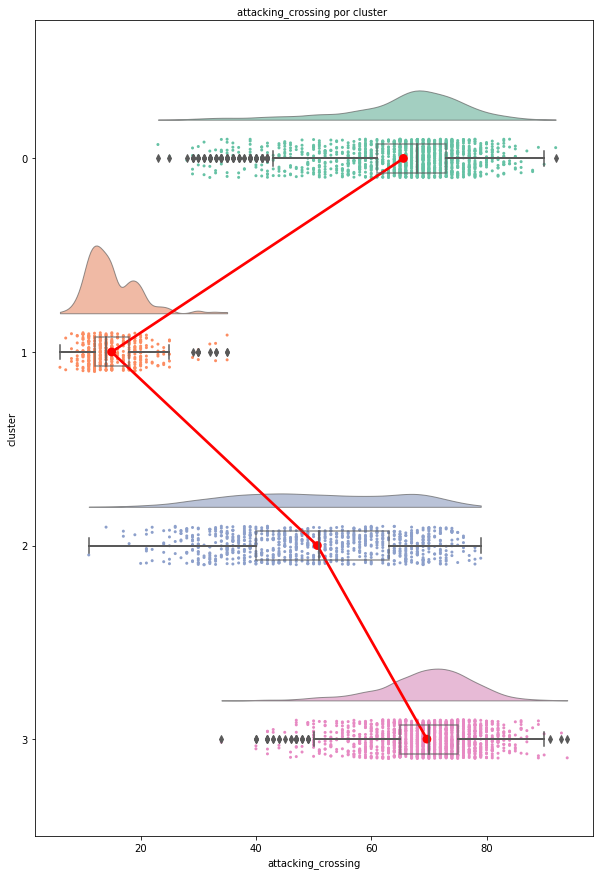

In [27]:
import ptitprince as pt
plt.figure(figsize=(10,15))
ax=pt.RainCloud(data=df_skills_pos,y='attacking_crossing',x=df_skills_pos.cluster,orient='h',pointplot = True,alpha = .65)
plt.title("attacking_crossing por cluster ",fontsize=10)
plt.show()

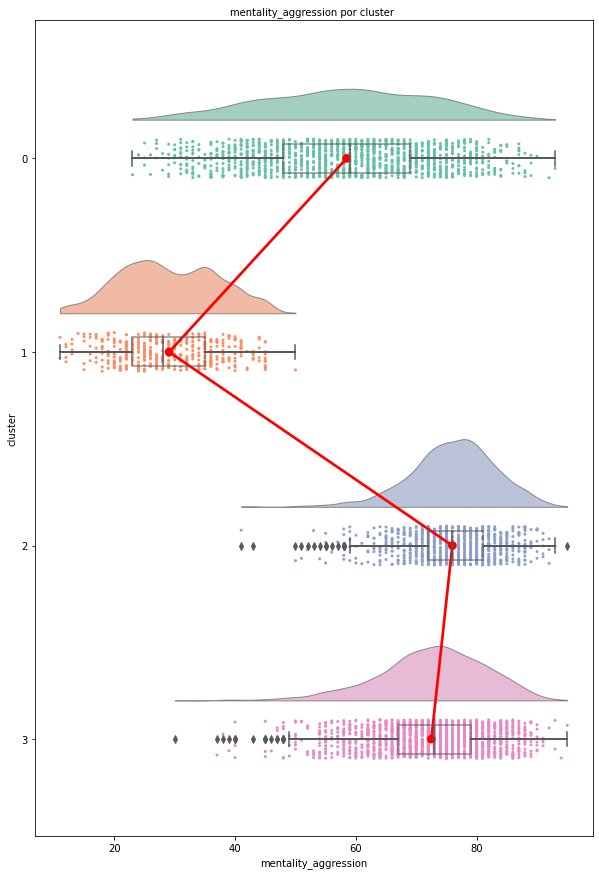

In [28]:
plt.figure(figsize=(10,15))

ax=pt.RainCloud(data=df_skills_pos,y='mentality_aggression',x=df_skills_pos.cluster,orient='h',pointplot = True,alpha = .65)

plt.title("mentality_aggression por cluster ",fontsize=10)
plt.show()

- Tabla de contingencia alguna categórica vs clusters:

Se utilizan las variables nationality y work_rate,segun las tablas se observa:
 - La mayoria de los jugadores que corresponden al cluster 1 (arqueros) son de nacionalidad española.
 - EL work_Rate corrrepodiente a high permecen en su mayoria a los jugadores del cluster 3
 - Todos los jugadores del cluster 1 tienen un work_Rate medium

In [29]:
pd.crosstab(df['nationality'], df_skills_pos['cluster']) 

cluster                     0   1    2    3
nationality                                
Albania                     0   2    3    3
Algeria                    14   2    0   11
Angola                      3   0    1    3
Antigua & Barbuda           0   0    1    0
Argentina                 116  33   70  109
Armenia                     1   0    0    1
Australia                   5   3    3    8
Austria                    17   7   12   28
Belgium                    31  10   14   37
Benin                       0   0    0    1
Bermuda                     1   0    0    0
Bolivia                     0   0    0    1
Bosnia Herzegovina          7   1    4   10
Brazil                    159  41  103  168
Bulgaria                    2   0    0    1
Burkina Faso                2   1    1    1
Burundi                     1   0    0    0
Cameroon                   10   1    9    6
Canada                      4   2    1    4
Cape Verde                  6   0    2    1
Central African Republic    0   0    0    1
Chad                        1   0    0    0
Chile                      13   4    9   18
China PR                    8   3    0    3
Colombia                   59   4   20   25
Comoros                     0   0    0    1
Congo                       1   1    1    1
Costa Rica                  1   1    2    1
Croatia                    17   2   13   20
Cuba                        0   0    0    1
Curacao                     0   1    0    0
Cyprus                      0   0    0    1
Czech Republic             12   6   11   31
DR Congo                    8   0    4    5
Denmark                    17   4   14   20
Dominican Republic          1   0    0    0
Ecuador                    14   3    7    7
Egypt                       7   2    2    4
England                    70  21   64   86
Equatorial Guinea           0   0    0    1
Estonia                     0   0    1    0
Finland                     2   2    2    4
France                     80  24   78  120
Gabon                       2   0    1    3
Gambia                      2   0    1    0
Georgia                     3   1    0    1
Germany                    57  35   57   87
Ghana                      12   0   10   16
Greece                     12   7    6   14
Guinea                      3   0    1    3
Guinea Bissau               1   0    0    3
Honduras                    2   0    0    2
Hungary                     4   2    2    2
Iceland                     3   0    5    3
Iran                        6   2    0    1
Iraq                        0   0    0    2
Israel                      6   0    0    1
Italy                      48  24   40   60
Ivory Coast                16   0   10   16
Jamaica                     3   1    2    2
Japan                      21   2    6   15
Kazakhstan                  1   0    0    0
Kenya                       1   0    0    1
Korea Republic             10   2    4   12
Kosovo                      4   0    1    5
Liberia                     0   0    0    1
Libya                       2   0    1    0
Lithuania                   0   1    0    0
Luxembourg                  0   0    1    0
Madagascar                  0   0    2    1
Mali                        8   1    5    7
Mexico                     18  14   17   35
Moldova                     0   0    1    1
Montenegro                  2   0    2    2
Morocco                    17   2    3   17
Mozambique                  0   0    2    1
Namibia                     0   0    1    0
Netherlands                37  11   26   54
New Caledonia               0   0    1    0
New Zealand                 1   1    1    2
Nigeria                    27   1    8    9
North Macedonia             3   1    0    5
Northern Ireland            0   0    2    4
Norway                     11   4    3   21
Panama                      0   1    1    1
Paraguay                   21   3   11   11
Peru                        4   3    2    6
Philippines                 0   1    0    0
Poland                     13   8    7  

In [30]:
pd.crosstab(df['work_rate'], df_skills_pos['cluster']) 

cluster          0    1    2    3
work_rate                        
High/High      144    0   30  293
High/Low       200    0    1   26
High/Medium    535    0   94  531
Low/High         0    0   87   22
Low/Low          3    0    1    1
Low/Medium       2    0   66   10
Medium/High     26    0  286  254
Medium/Low     184    0    0   14
Medium/Medium  371  444  356  531

- Silohuette

In [31]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

For n_clusters = 2 The average silhouette_score is : 0.6413157990914239
For n_clusters = 3 The average silhouette_score is : 0.3368735183485735
For n_clusters = 4 The average silhouette_score is : 0.30988045957867183
For n_clusters = 5 The average silhouette_score is : 0.2774150713305208
For n_clusters = 6 The average silhouette_score is : 0.2381302113927746


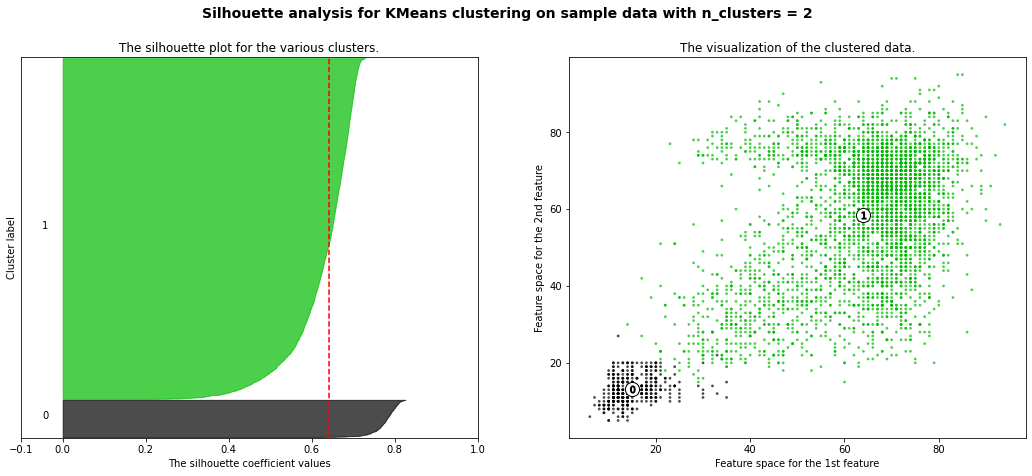

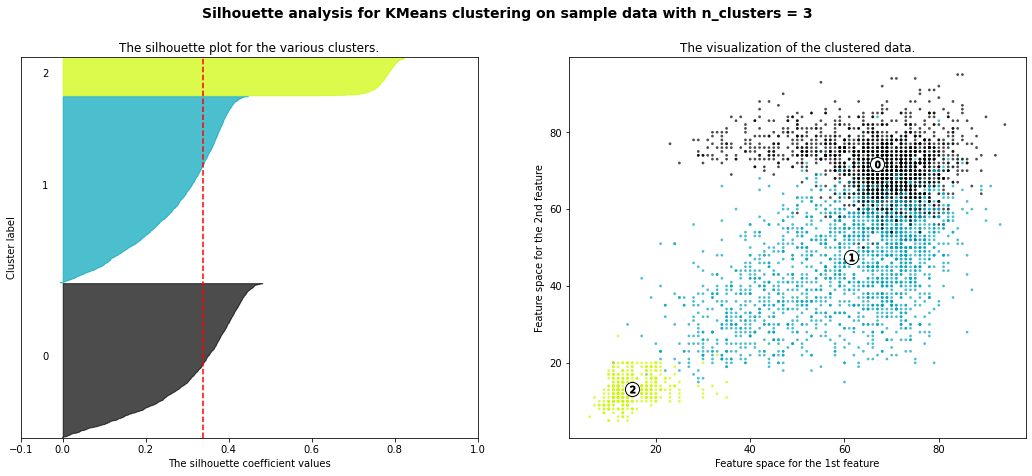

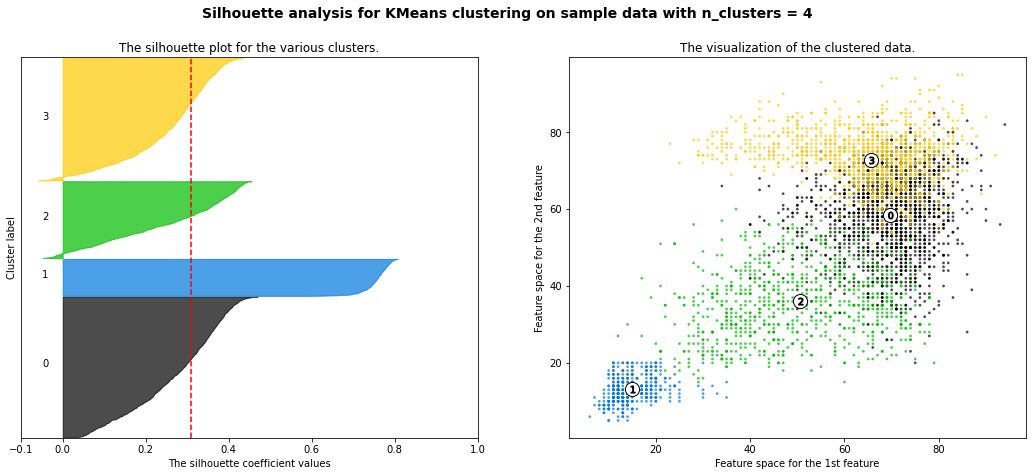

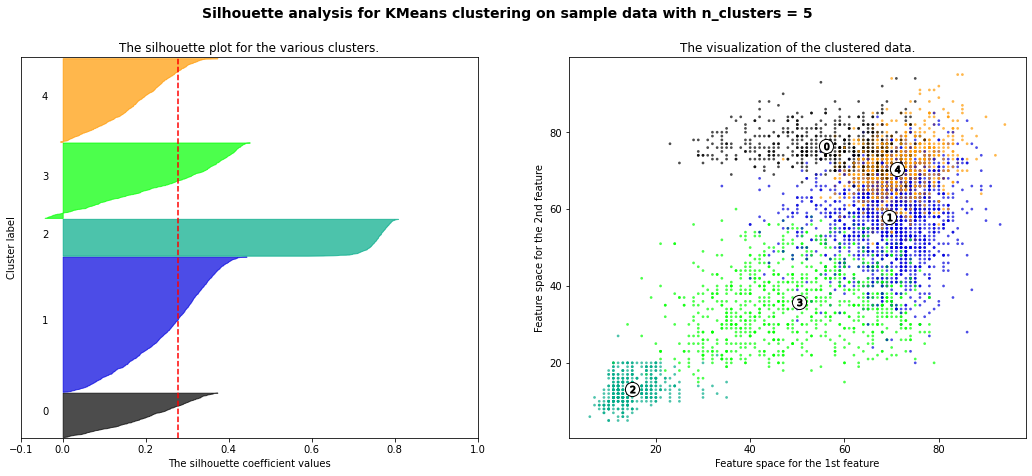

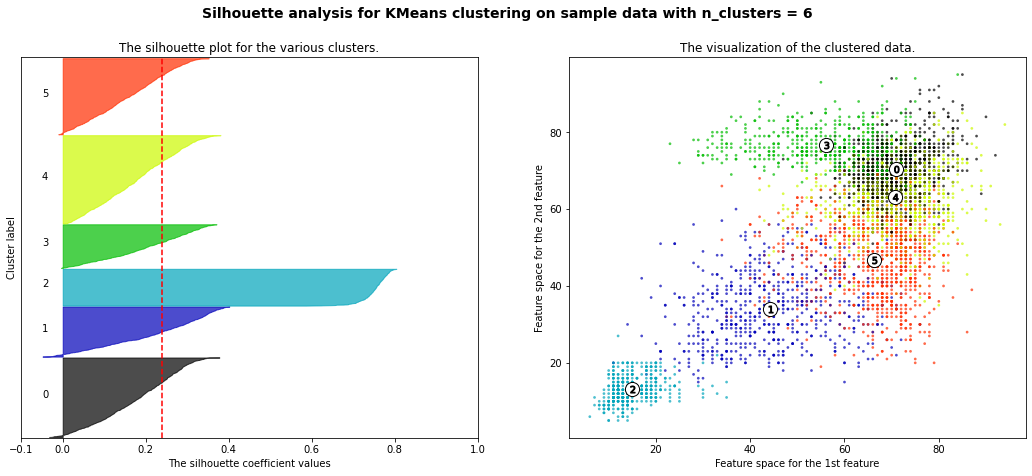

In [32]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X=df_skills
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
       X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

El análisis de silueta nos ayuda a elegir un valor óptimo de n_clusters. Segun los graficos y los valores de los coeficientes de silhouette nos dicen que los n_clusters de 5 y 6 son una mala elección para los datos dados debido a las fluctuaciones del tamaño de las parcelas de lasilueta.  Ademas cabe recalcar que par n=2 existe una clara separarcion de arqueros y el resto de los jugadores.

# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio/bandwith (de cobertura para cálculo de media). (Probar con varios)

In [33]:
df_skills_3=df_n[skills_ratings]
df_skills_3=df_skills_3.drop(["defending_marking"], axis=1)

In [34]:
# Se probo bandwith =2,4,6. EL unico caso que nos dio un numero de cluster cercano al esperado es cuando el bandwith = 2. 
#
ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills_3)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 3


In [35]:
df_skills_3["cluster"] = clusters2

In [36]:
df_skills_3

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                     85                   95                          70   
1                     84                   95                          90   
2                     13                   11                          15   
3                     71                   94                          85   
4                     85                   87                          62   
...                  ...                  ...                         ...   
4507                  76                   54                          54   
4508                  68                   68                          48   
4509                  67                   55                          51   
4510                  14                    6                          13   
4511                  59                   70                          50   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                          91                 88               96   
1                          82                 86               88   
2                          43                 13               12   
3                          84                 89               85   
4                          87                 87               95   
...                       ...                ...              ...   
4507                       67                 55               70   
4508                       69                 61               73   
4509                       73                 51               73   
4510                       21                  9                9   
4511                       75                 61               73   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0              93                 94                  91                  96   
1              81                 76                  77                  92   
2              13                 14                  40                  30   
3              79                 85                  70                  88   
4              88                 89                  81                  95   
...           ...                ...                 ...                 ...   
4507           74                 65                  64                  68   
4508           53                 42                  57                  71   
4509           81                 63                  71                  75   
4510           14                 11                  21                  18   
4511           59                 59                  73                  74   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                        91                     80                91   
1                        87                     91                87   
2                        43                     60                67   
3                        77                     78                77   
4                        94                     89                96   
...                     ...                    ...               ...   
4507                     87                     85                77   
4508                     83                     82                81   
4509                     79                     73                80   
4510                     28                     16                21   
4511                     66                     67                74   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                     94                95                86             68   
1                     95                71                94             95   
2                     88                49                59             78   
3                     93                82                89             84   
4                     91       

**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

- Cantidad de observaciones por Cluster:
 
En el agrupamiento realizado por mean-shift  se observa que el numero de cluster obtenido no coincide con los tipos de jugadores encontrados manualmente.

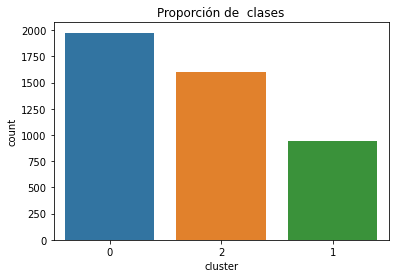

0    1975
2    1599
1     938
Name: cluster, dtype: int64

In [37]:
sns.countplot(df_skills_3.cluster, order=df_skills_3.cluster.value_counts().index)
plt.title("Proporción de  clases")
plt.show()
df_skills_3["cluster"].value_counts()

- Análisis descriptivo separando por Cluster

In [38]:
df_cluster_m_0=df_skills_3[df_skills_3["cluster"]==0]
df_cluster_m_1=df_skills_3[df_skills_3["cluster"]==1]
df_cluster_m_2=df_skills_3[df_skills_3["cluster"]==2]


In [39]:
df_cluster_m_0.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1975.000000          1975.000000                 1975.000000   
mean            61.252658            46.298734                   64.241519   
std             14.558183            13.645604                   11.303983   
min             11.000000            15.000000                   22.000000   
25%             52.000000            36.000000                   57.000000   
50%             66.000000            47.000000                   65.000000   
75%             72.000000            57.000000                   73.000000   
max             87.000000            79.000000                   89.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1975.000000        1975.000000      1975.000000   
mean                 70.300253          45.352911        64.598481   
std                   5.511844          13.814868        10.946878   
min                  42.000000          11.000000        23.000000   
25%                  67.000000          34.000000        59.000000   
50%                  71.000000          45.000000        67.000000   
75%                  74.000000          56.000000        73.000000   
max                  86.000000          80.000000        86.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1975.000000        1975.000000         1975.000000         1975.000000   
mean     56.056709          48.951899           65.699241           68.982278   
std      15.699361          16.045030            7.415698            6.720215   
min      14.000000          10.000000           20.000000           33.000000   
25%      44.000000          35.000000           62.000000           65.000000   
50%      59.000000          48.000000           67.000000           70.000000   
75%      69.000000          62.000000           71.000000           74.000000   
max      90.000000          89.000000           87.000000           84.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1975.000000            1975.000000       1975.000000   
mean               67.792911              68.474937         66.809114   
std                12.583708              12.402987         12.572365   
min                28.000000              30.000000         26.000000   
25%                61.000000              63.000000         60.000000   
50%                69.000000              70.000000         69.000000   
75%                76.000000              77.000000         75.000000   
max                96.000000              96.000000         95.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1975.000000       1975.000000       1975.000000    1975.000000   
mean            70.671392         65.961519         63.145316      70.584304   
std              4.571161         13.090734         11.572364      11.285592   
min             54.000000         27.000000         22.000000      31.000000   
25%             68.000000         59.000000         56.000000      65.000000   
50%             70.000000         68.000000         65.000000      72.000000   
75%             74.000000         75.000000         72.000000      78.000000   
max             86.000000         96.000000         89.000000      94.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1975.000000     1975.000000       1975.000000           1975.000000   
mean       73.038987       70.981266         52.675443             72.641013   
std        10.072533       10.923709         15.330254              9.341611   
min        30.000000       30.000000         12.000000             29.000000   
25%        68.000000       65.000000         41.000000             68.000000   
50%        74.000000       72.000000         55.000000             74.000000   
75% 

In [40]:
df_cluster_m_1.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count          938.000000           938.000000                  938.000000   
mean            69.270789            66.382729                   64.157783   
std              9.655608             8.598330                   10.903606   
min             33.000000            34.000000                   31.000000   
25%             65.000000            60.000000                   58.000000   
50%             70.000000            67.000000                   65.000000   
75%             76.000000            72.000000                   72.000000   
max             94.000000            94.000000                   93.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count               938.000000         938.000000       938.000000   
mean                 77.849680          63.093817        75.199360   
std                   4.599407          11.238358         6.350969   
min                  63.000000          26.000000        45.000000   
25%                  75.000000          56.000000        72.000000   
50%                  78.000000          64.000000        75.000000   
75%                  81.000000          71.000000        79.000000   
max                  94.000000          90.000000        92.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count   938.000000         938.000000          938.000000          938.000000   
mean     69.513859          63.384861           74.074627           77.638593   
std      10.891055          12.867773            6.342651            4.842502   
min      30.000000          28.000000           37.000000           58.000000   
25%      64.000000          55.000000           71.000000           74.000000   
50%      71.000000          65.000000           75.000000           77.000000   
75%      78.000000          73.000000           78.000000           81.000000   
max      92.000000          93.000000           93.000000           92.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count             938.000000             938.000000        938.000000   
mean               67.811301              66.973348         70.962687   
std                11.438276              11.623144         10.097798   
min                27.000000              29.000000         32.000000   
25%                62.000000              61.000000         65.000000   
50%                68.000000              68.000000         72.000000   
75%                76.000000              75.000000         77.000000   
max                93.000000              95.000000         94.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count          938.000000        938.000000        938.000000     938.000000   
mean            75.696162         69.704691         75.997868      67.360341   
std              5.320307         11.636948          6.145687      12.070418   
min             60.000000         30.000000         47.000000      30.000000   
25%             72.000000         63.250000         72.000000      61.000000   
50%             75.000000         71.000000         76.000000      68.000000   
75%             79.000000         77.000000         80.000000      76.000000   
max             94.000000         95.000000         95.000000      93.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count     938.000000      938.000000        938.000000            938.000000   
mean       77.905117       71.199360         71.448827             72.479744   
std         9.321974        9.659171          7.563749             10.105216   
min        32.000000       33.000000         36.000000             29.000000   
25%        73.000000       65.000000         67.000000             67.000000   
50%        78.000000       72.000000         72.000000             74.000000   
75% 

In [41]:
df_cluster_m_2.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1599.000000          1599.000000                 1599.000000   
mean            50.417761            56.383990                   48.883052   
std             24.045469            27.423716                   24.336877   
min              6.000000             5.000000                    7.000000   
25%             20.000000            18.000000                   20.000000   
50%             62.000000            70.000000                   54.000000   
75%             69.000000            75.000000                   70.000000   
max             89.000000            95.000000                   93.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1599.000000        1599.000000      1599.000000   
mean                 59.509068          52.229518        58.849281   
std                  19.089435          25.109382        27.487814   
min                  11.000000           4.000000         7.000000   
25%                  43.000000          19.000000        21.000000   
50%                  68.000000          64.000000        73.000000   
75%                  72.000000          71.000000        78.000000   
max                  91.000000          89.000000        96.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1599.000000        1599.000000         1599.000000         1599.000000   
mean     52.368355          46.394622           51.423390           60.783615   
std      24.625735          22.782890           16.785482           24.156472   
min       6.000000           7.000000            9.000000            5.000000   
25%      21.000000          20.000000           38.000000           32.000000   
50%      62.000000          51.000000           56.000000           73.000000   
75%      71.000000          66.000000           65.000000           77.000000   
max      94.000000          94.000000           91.000000           96.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1599.000000            1599.000000       1599.000000   
mean               68.294559              67.995622         68.140713   
std                18.014149              17.538318         17.366933   
min                17.000000              15.000000         19.000000   
25%                54.000000              54.000000         57.000000   
50%                74.000000              73.000000         73.000000   
75%                82.000000              81.000000         81.000000   
max                97.000000              96.000000         96.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1599.000000       1599.000000       1599.000000    1599.000000   
mean            72.037523         64.584740         68.573483      66.882427   
std              5.624445         16.937607         11.365724      12.458188   
min             50.000000         20.000000         33.000000      31.000000   
25%             68.000000         52.000000         58.000000      59.000000   
50%             72.000000         68.000000         72.000000      68.000000   
75%             75.000000         77.000000         77.000000      75.000000   
max             95.000000         95.000000         94.000000      95.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1599.000000     1599.000000       1599.000000           1599.000000   
mean       59.966854       66.540338         53.803002             49.427767   
std        17.990424       12.567145         25.499478             17.878806   
min        15.000000       27.000000          4.000000             11.000000   
25%        42.000000       59.000000         18.000000             35.000000   
50%        67.000000       67.000000         66.000000             49.000000   
75% 

En los siguientes graficos se muestra los diagramas de caja y de distribucion de cada uno de los cluster para una skills en particular. Los siguientes graficos se observa:
-  Para las varibales attacking_crossing /mentality_aggression el cluster 0/1  posee los puntaje mas alto.

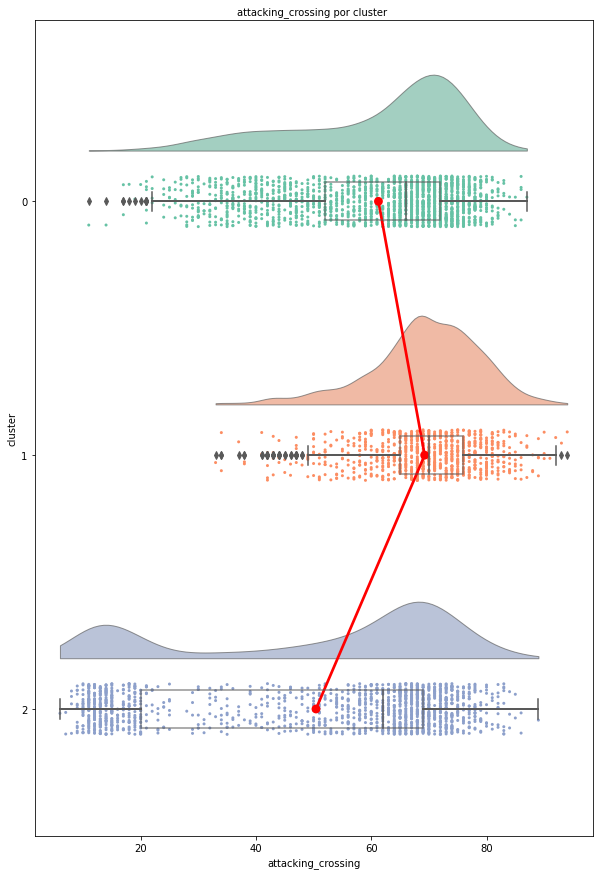

In [42]:
plt.figure(figsize=(10,15))
ax=pt.RainCloud(data=df_skills_3,y='attacking_crossing',x=df_skills_3.cluster,orient='h',pointplot = True,alpha = .65)
plt.title("attacking_crossing por cluster ",fontsize=10)
plt.show()

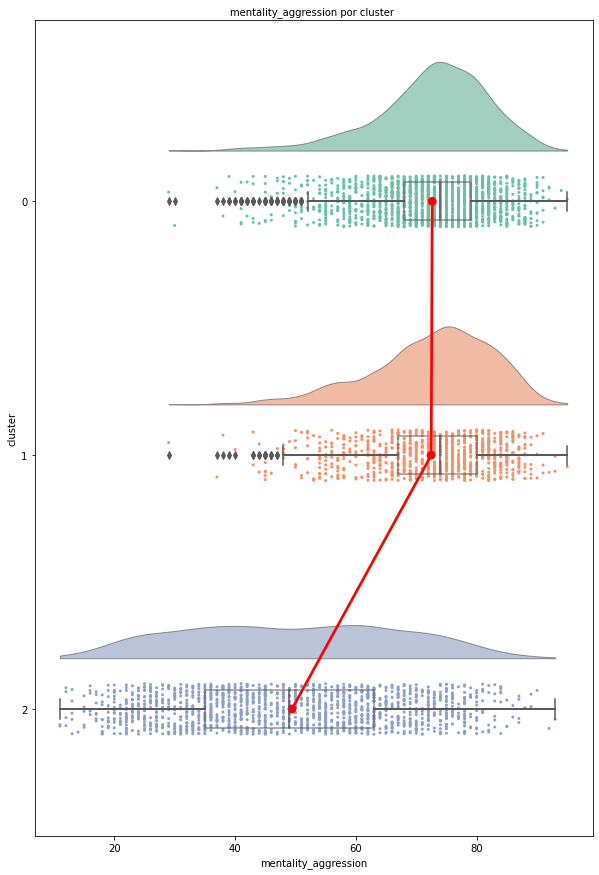

In [43]:
plt.figure(figsize=(10,15))

ax=pt.RainCloud(data=df_skills_3,y='mentality_aggression',x=df_skills_3.cluster,orient='h',pointplot = True,alpha = .65)

plt.title("mentality_aggression por cluster ",fontsize=10)
plt.show()

- Tabla de contingencia alguna categórica vs clusters


In [44]:
pd.crosstab(df['nationality'], df_skills_3['cluster']) 

cluster                     0    1    2
nationality                            
Albania                     6    0    2
Algeria                     9    5   13
Angola                      3    1    3
Antigua & Barbuda           1    0    0
Argentina                 139   64  125
Armenia                     0    1    1
Australia                   8    5    6
Austria                    25   18   21
Belgium                    33   24   35
Benin                       1    0    0
Bermuda                     0    0    1
Bolivia                     1    0    0
Bosnia Herzegovina          7    9    6
Brazil                    223   84  164
Bulgaria                    1    1    1
Burkina Faso                1    1    3
Burundi                     0    0    1
Cameroon                   13    3   10
Canada                      4    1    6
Cape Verde                  3    0    6
Central African Republic    0    1    0
Chad                        0    0    1
Chile                      20   10   14
China PR                    4    1    9
Colombia                   42    8   58
Comoros                     1    0    0
Congo                       1    1    2
Costa Rica                  3    0    2
Croatia                    23   14   15
Cuba                        0    1    0
Curacao                     0    0    1
Cyprus                      0    1    0
Czech Republic             34   12   14
DR Congo                    9    0    8
Denmark                    28   12   15
Dominican Republic          0    0    1
Ecuador                    14    1   16
Egypt                       6    2    7
England                   123   49   69
Equatorial Guinea           0    1    0
Estonia                     1    0    0
Finland                     5    1    4
France                    139   78   85
Gabon                       2    2    2
Gambia                      1    0    2
Georgia                     1    0    4
Germany                   104   52   80
Ghana                      18   12    8
Greece                     16    6   17
Guinea                      3    2    2
Guinea Bissau               2    1    1
Honduras                    2    0    2
Hungary                     3    1    6
Iceland                     6    2    3
Iran                        1    0    8
Iraq                        2    0    0
Israel                      2    0    5
Italy                      71   34   67
Ivory Coast                17    9   16
Jamaica                     6    0    2
Japan                      23    2   19
Kazakhstan                  1    0    0
Kenya                       0    1    1
Korea Republic             14    3   11
Kosovo                      5    1    4
Liberia                     1    0    0
Libya                       2    0    1
Lithuania                   0    0    1
Luxembourg                  1    0    0
Madagascar                  3    0    0
Mali                       10    2    9
Mexico                     36   20   28
Moldova                     1    1    0
Montenegro                  2    2    2
Morocco                    12   12   15
Mozambique                  3    0    0
Namibia                     1    0    0
Netherlands                53   33   42
New Caledonia               1    0    0
New Zealand                 3    0    2
Nigeria                    14    6   25
North Macedonia             2    4    3
Northern Ireland            5    1    0
Norway                     16   11   12
Panama                      1    1    1
Paraguay                   19    6   21
Peru                        7    2    6
Philippines                 0    0    1
Poland                     13    8   17
Portugal                   75   32   53
Puerto Rico                 1    0    0
Republic of Ireland        15    5    5
Romania                    11    5   13
Russia                     20    7   18
Saint Kitts and Nevis       0    1    0
Saudi Arabia                4    1    1
Scotland                   14   12    7
Senegal                    13    5   17


In [45]:
pd.crosstab(df['work_rate'], df_skills_3['cluster']) 

cluster          0    1    2
work_rate                   
High/High      179  196   92
High/Low        29   22  176
High/Medium    489  240  431
Low/High        98   11    0
Low/Low          1    1    3
Low/Medium      71    6    1
Medium/High    398  148   20
Medium/Low      21   25  152
Medium/Medium  689  289  724

-  Coefieciente Silohuette: Podemos decir que los grupos no están bien separados entre sí ya que la puntuación de la silueta esta lejos del 1.

In [46]:
metrics.silhouette_score(df_skills, clusters2)

0.04524089402228348

**Pregunta: normalizamos/estandarizamos la base?**

Como los skills de los jugadores tienen un rango que varian de 1-100, no es necesario estandarizar.

# Clustering-Jerarquico

In [47]:
df_skills_j=df_n[skills_ratings]
df_skills_j=df_skills_j.drop(["defending_marking"], axis=1)

Creamos el dendograma para encontrar el número óptimo de clusters

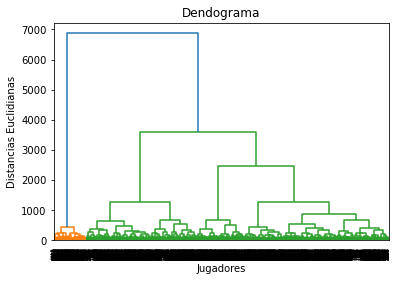

In [48]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
dendrogram = sch.dendrogram(sch.linkage(df_skills_j, method = 'ward')) 
plt.xlabel('Jugadores')
plt.ylabel('Distancias Euclidianas')
plt.show()

Podemos observar que la distancia máxima la marca la línea azul oscuro que une los clusters naranja y verdes, por lo que si realizamos el corte en esa zona obtenemos:4 clusters

In [50]:
hc = AgglomerativeClustering(n_clusters = 4, 
                    affinity = 'euclidean', 
                    linkage = 'ward')

y_hc = hc.fit_predict(df_skills_j)


In [51]:
df_skills_j["cluster"] = y_hc

In [52]:
df_skills_j

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                     85                   95                          70   
1                     84                   95                          90   
2                     13                   11                          15   
3                     71                   94                          85   
4                     85                   87                          62   
...                  ...                  ...                         ...   
4507                  76                   54                          54   
4508                  68                   68                          48   
4509                  67                   55                          51   
4510                  14                    6                          13   
4511                  59                   70                          50   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                          91                 88               96   
1                          82                 86               88   
2                          43                 13               12   
3                          84                 89               85   
4                          87                 87               95   
...                       ...                ...              ...   
4507                       67                 55               70   
4508                       69                 61               73   
4509                       73                 51               73   
4510                       21                  9                9   
4511                       75                 61               73   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0              93                 94                  91                  96   
1              81                 76                  77                  92   
2              13                 14                  40                  30   
3              79                 85                  70                  88   
4              88                 89                  81                  95   
...           ...                ...                 ...                 ...   
4507           74                 65                  64                  68   
4508           53                 42                  57                  71   
4509           81                 63                  71                  75   
4510           14                 11                  21                  18   
4511           59                 59                  73                  74   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                        91                     80                91   
1                        87                     91                87   
2                        43                     60                67   
3                        77                     78                77   
4                        94                     89                96   
...                     ...                    ...               ...   
4507                     87                     85                77   
4508                     83                     82                81   
4509                     79                     73                80   
4510                     28                     16                21   
4511                     66                     67                74   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                     94                95                86             68   
1                     95                71                94             95   
2                     88                49                59             78   
3                     93                82                89             84   
4                     91       

- Cantidad de observaciones por Cluster:

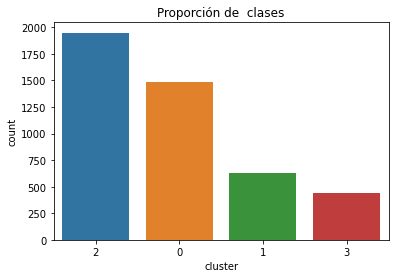

2    1949
0    1487
1     632
3     444
Name: cluster, dtype: int64

In [53]:
sns.countplot(df_skills_j.cluster, order=df_skills_j.cluster.value_counts().index)
plt.title("Proporción de  clases")
plt.show()
df_skills_j["cluster"].value_counts()

- Análisis descriptivo separando por Cluster

In [56]:
df_cluster_j_0=df_skills_j[df_skills_j["cluster"]==0]
df_cluster_j_1=df_skills_j[df_skills_j["cluster"]==1]
df_cluster_j_2=df_skills_j[df_skills_j["cluster"]==2]
df_cluster_j_3=df_skills_j[df_skills_j["cluster"]==3]

In [57]:
df_cluster_j_0.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1487.000000          1487.000000                 1487.000000   
mean            65.767317            72.590451                   60.848016   
std             10.897463             6.404469                   14.098138   
min             23.000000            51.000000                   20.000000   
25%             61.000000            68.000000                   49.000000   
50%             68.000000            73.000000                   62.000000   
75%             73.000000            76.000000                   72.000000   
max             92.000000            95.000000                   93.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1487.000000        1487.000000      1487.000000   
mean                 71.667115          67.332213        75.873571   
std                   5.666376           8.607795         5.864683   
min                  53.000000          32.000000        57.000000   
25%                  68.000000          62.000000        72.000000   
50%                  72.000000          68.000000        76.000000   
75%                  75.000000          73.000000        80.000000   
max                  92.000000          90.000000        96.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1487.000000        1487.000000         1487.000000         1487.000000   
mean     68.160726          60.893746           62.044385           75.853396   
std      10.590588          13.693118           10.439761            4.961768   
min      26.000000          22.000000           25.000000           57.000000   
25%      62.000000          51.000000           56.000000           73.000000   
50%      69.000000          63.000000           64.000000           75.000000   
75%      76.000000          72.000000           69.000000           79.000000   
max      94.000000          94.000000           91.000000           96.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1487.000000            1487.000000       1487.000000   
mean               76.061870              75.377270         76.248151   
std                11.154196              10.583557         10.360313   
min                27.000000              30.000000         30.000000   
25%                70.000000              69.000000         71.000000   
50%                77.000000              76.000000         77.000000   
75%                84.000000              82.000000         84.000000   
max                97.000000              96.000000         96.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1487.000000       1487.000000       1487.000000    1487.000000   
mean            72.546066         72.458642         74.795562      66.262946   
std              5.748579         12.180982          6.561022      13.564317   
min             56.000000         27.000000         39.000000      30.000000   
25%             69.000000         66.000000         71.000000      58.000000   
50%             72.000000         74.000000         75.000000      68.000000   
75%             76.000000         80.000000         79.000000      75.500000   
max             95.000000         96.000000         94.000000      95.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1487.000000     1487.000000       1487.000000           1487.000000   
mean       69.915938       66.098184         69.971083             58.487559   
std         9.170234       13.386974          7.021681             13.833647   
min        30.000000       27.000000         40.000000             23.000000   
25%        66.000000       58.000000         66.000000             48.000000   
50%        71.000000       66.000000         70.000000             59.000000   
75% 

In [58]:
df_cluster_j_1.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count          632.000000           632.000000                  632.000000   
mean            44.985759            34.606013                   74.376582   
std             12.121994             9.515930                    5.420857   
min             11.000000            15.000000                   41.000000   
25%             36.000000            27.750000                   72.000000   
50%             44.000000            34.000000                   75.000000   
75%             54.000000            41.000000                   78.000000   
max             76.000000            60.000000                   89.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count               632.000000         632.000000       632.000000   
mean                 66.854430          34.338608        52.606013   
std                   6.130205           9.859355         9.464162   
min                  42.000000          11.000000        23.000000   
25%                  63.750000          27.000000        46.750000   
50%                  67.000000          33.000000        53.000000   
75%                  71.000000          40.000000        59.000000   
max                  80.000000          62.000000        71.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count   632.000000         632.000000          632.000000          632.000000   
mean     39.783228          36.882911           62.449367           62.522152   
std      10.832634          12.124900            8.175994            6.412361   
min      14.000000          10.000000           20.000000           33.000000   
25%      32.000000          28.000000           58.000000           58.000000   
50%      38.000000          34.000000           64.000000           63.000000   
75%      47.000000          43.000000           68.000000           67.000000   
max      76.000000          79.000000           84.000000           80.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count             632.000000             632.000000        632.000000   
mean               55.669304              58.528481         53.325949   
std                11.690263              12.777846         10.898818   
min                28.000000              30.000000         26.000000   
25%                49.000000              51.000000         47.000000   
50%                58.000000              61.000000         54.000000   
75%                64.000000              68.000000         62.000000   
max                83.000000              88.000000         77.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count          632.000000        632.000000        632.000000     632.000000   
mean            70.593354         52.496835         56.636076      73.125000   
std              4.844735         11.090036         12.212091      11.650288   
min             54.000000         27.000000         22.000000      31.000000   
25%             67.000000         44.000000         48.000000      69.000000   
50%             70.000000         54.000000         57.000000      75.000000   
75%             74.000000         60.000000         66.000000      80.000000   
max             85.000000         80.000000         85.000000      94.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count     632.000000      632.000000        632.000000            632.000000   
mean       66.924051       80.764241         39.131329             77.017405   
std        10.392179        6.045505         13.096866              6.205770   
min        30.000000       63.000000         12.000000             54.000000   
25%        62.000000       77.000000         29.000000             73.000000   
50%        68.000000       80.000000         37.000000             77.000000   
75% 

In [59]:
df_cluster_j_2.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1949.000000          1949.000000                 1949.000000   
mean            68.597229            55.535659                   62.139046   
std              8.643487            12.121831                    9.986575   
min             34.000000            20.000000                   22.000000   
25%             64.000000            48.000000                   56.000000   
50%             70.000000            57.000000                   62.000000   
75%             74.000000            65.000000                   69.000000   
max             94.000000            88.000000                   92.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1949.000000        1949.000000      1949.000000   
mean                 74.181119          53.567470        71.466393   
std                   5.383786          12.866842         6.388237   
min                  52.000000          16.000000        47.000000   
25%                  70.000000          44.000000        68.000000   
50%                  74.000000          55.000000        72.000000   
75%                  78.000000          63.000000        76.000000   
max                  94.000000          87.000000        92.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1949.000000        1949.000000         1949.000000         1949.000000   
mean     64.741406          56.330426           70.034890           73.786557   
std      11.333603          14.250891            7.259548            5.207659   
min      21.000000          18.000000           37.000000           55.000000   
25%      58.000000          45.000000           66.000000           70.000000   
50%      66.000000          57.000000           71.000000           74.000000   
75%      73.000000          68.000000           75.000000           77.000000   
max      91.000000          93.000000           93.000000           92.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1949.000000            1949.000000       1949.000000   
mean               71.121601              70.815290         71.770139   
std                 9.823916              10.514816          8.130513   
min                31.000000              29.000000         33.000000   
25%                66.000000              65.000000         67.000000   
50%                72.000000              72.000000         72.000000   
75%                77.000000              78.000000         77.000000   
max                96.000000              96.000000         95.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1949.000000       1949.000000       1949.000000    1949.000000   
mean            72.638276         70.849666         69.336070      69.837352   
std              5.312705          9.359327          9.907137      10.471224   
min             56.000000         31.000000         28.000000      31.000000   
25%             69.000000         65.000000         64.000000      63.000000   
50%             72.000000         71.000000         71.000000      71.000000   
75%             76.000000         77.000000         76.000000      77.000000   
max             94.000000         94.000000         95.000000      93.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1949.000000     1949.000000       1949.000000           1949.000000   
mean       77.863520       69.074397         62.665983             72.822473   
std         8.143216        9.177807         11.984409              8.777555   
min        41.000000       30.000000         21.000000             30.000000   
25%        73.000000       64.000000         56.000000             68.000000   
50%        78.000000       70.000000         65.000000             73.000000   
75% 

In [60]:
df_cluster_j_3.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count          444.000000           444.000000                  444.000000   
mean            14.966216            13.092342                   14.921171   
std              4.517958             3.400708                    4.361809   
min              6.000000             5.000000                    7.000000   
25%             12.000000            11.000000                   12.000000   
50%             14.000000            13.000000                   14.000000   
75%             18.000000            15.000000                   17.000000   
max             35.000000            27.000000                   47.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count               444.000000         444.000000       444.000000   
mean                 30.677928          13.605856        15.450450   
std                   9.164282           3.506854         4.391123   
min                  11.000000           4.000000         7.000000   
25%                  24.000000          11.000000        12.000000   
50%                  30.000000          13.000000        15.000000   
75%                  36.000000          16.000000        18.000000   
max                  61.000000          26.000000        30.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count   444.000000         444.000000          444.000000          444.000000   
mean     15.707207          15.029279           29.815315           22.837838   
std       5.275681           4.865834           10.242087            6.555945   
min       6.000000           7.000000            9.000000            5.000000   
25%      12.000000          12.000000           22.000000           19.000000   
50%      15.000000          14.000000           29.000000           22.000000   
75%      18.000000          17.000000           35.000000           25.000000   
max      69.000000          74.000000           67.000000           47.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count             444.000000             444.000000        444.000000   
mean               44.590090              44.344595         46.182432   
std                 9.481763               9.120250         11.741403   
min                17.000000              15.000000         19.000000   
25%                38.000000              38.000000         37.000000   
50%                45.000000              45.000000         45.000000   
75%                51.000000              50.250000         55.000000   
max                65.000000              65.000000         71.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count          444.000000        444.000000        444.000000     444.000000   
mean            71.405405         44.860360         52.918919      64.576577   
std              5.433993         10.563293          4.564828      10.190997   
min             50.000000         20.000000         33.000000      32.000000   
25%             68.000000         38.000000         50.000000      59.000000   
50%             71.000000         45.000000         53.000000      67.000000   
75%             74.000000         53.000000         56.000000      72.000000   
max             88.000000         69.000000         70.000000      85.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count     444.000000      444.000000        444.000000            444.000000   
mean       34.227477       66.247748         13.896396             29.076577   
std         6.677347        9.561344          3.340440              8.083285   
min        15.000000       33.000000          4.000000             11.000000   
25%        30.000000       60.000000         12.000000             23.000000   
50%        34.000000       67.500000         14.000000             28.000000   
75% 

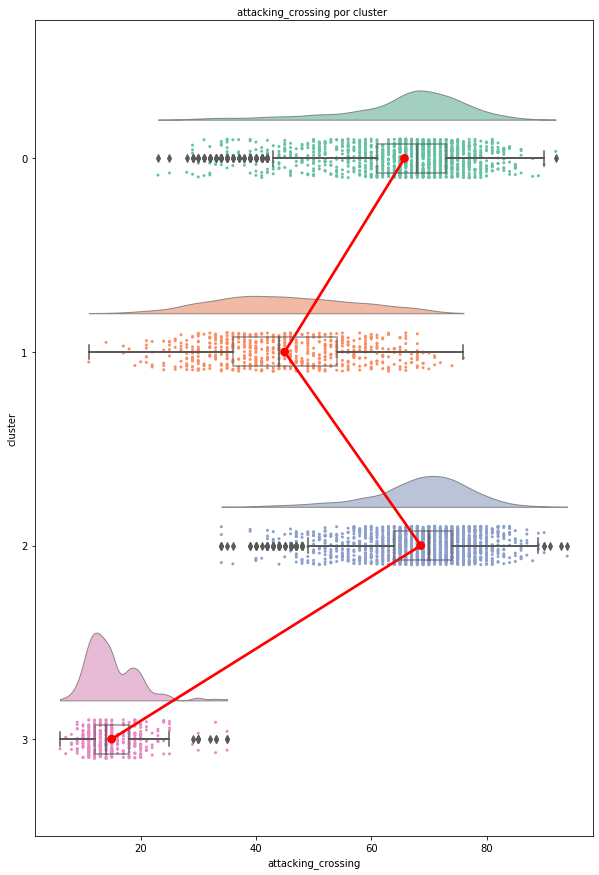

In [62]:
plt.figure(figsize=(10,15))
ax=pt.RainCloud(data=df_skills_j,y='attacking_crossing',x=df_skills_j.cluster,orient='h',pointplot = True,alpha = .65)
plt.title("attacking_crossing por cluster ",fontsize=10)
plt.show()

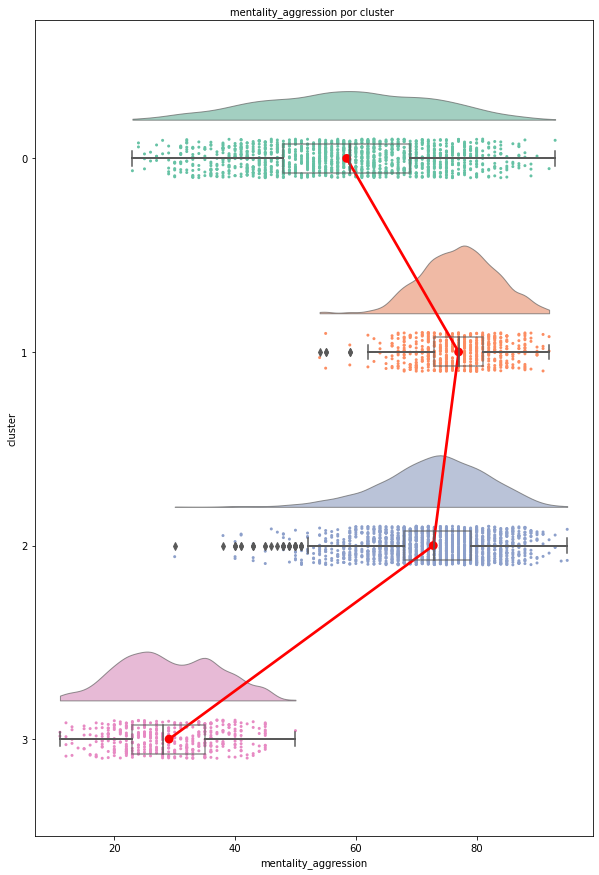

In [63]:
plt.figure(figsize=(10,15))

ax=pt.RainCloud(data=df_skills_j,y='mentality_aggression',x=df_skills_j.cluster,orient='h',pointplot = True,alpha = .65)

plt.title("mentality_aggression por cluster ",fontsize=10)
plt.show()

- Tabla de contingencia alguna categórica vs clusters

In [64]:
pd.crosstab(df['nationality'], df_skills_j['cluster']) 

cluster                     0   1    2   3
nationality                               
Albania                     0   2    4   2
Algeria                    13   0   12   2
Angola                      3   1    3   0
Antigua & Barbuda           0   0    1   0
Argentina                 118  50  127  33
Armenia                     2   0    0   0
Australia                   4   1   11   3
Austria                    18   9   30   7
Belgium                    31  10   41  10
Benin                       0   0    1   0
Bermuda                     1   0    0   0
Bolivia                     0   0    1   0
Bosnia Herzegovina          8   3   10   1
Brazil                    159  74  197  41
Bulgaria                    2   0    1   0
Burkina Faso                2   1    1   1
Burundi                     1   0    0   0
Cameroon                   10   6    9   1
Canada                      4   0    5   2
Cape Verde                  6   2    1   0
Central African Republic    0   0    1   0
Chad                        1   0    0   0
Chile                      14   4   22   4
China PR                    8   0    3   3
Colombia                   58  14   32   4
Comoros                     0   0    1   0
Congo                       1   0    2   1
Costa Rica                  1   2    1   1
Croatia                    17  12   21   2
Cuba                        0   0    1   0
Curacao                     0   0    0   1
Cyprus                      0   0    1   0
Czech Republic             11   8   35   6
DR Congo                    8   3    6   0
Denmark                    17   9   25   4
Dominican Republic          1   0    0   0
Ecuador                    14   5    9   3
Egypt                       6   2    5   2
England                    71  43  106  21
Equatorial Guinea           0   0    1   0
Estonia                     0   1    0   0
Finland                     2   1    5   2
France                     83  47  148  24
Gabon                       2   1    3   0
Gambia                      2   1    0   0
Georgia                     3   0    1   1
Germany                    59  41  101  35
Ghana                      13   6   19   0
Greece                     12   5   15   7
Guinea                      3   1    3   0
Guinea Bissau               1   0    3   0
Honduras                    2   0    2   0
Hungary                     4   2    2   2
Iceland                     3   4    4   0
Iran                        6   0    1   2
Iraq                        0   0    2   0
Israel                      6   0    1   0
Italy                      49  29   70  24
Ivory Coast                17   8   17   0
Jamaica                     3   2    2   1
Japan                      22   4   16   2
Kazakhstan                  1   0    0   0
Kenya                       1   0    1   0
Korea Republic             10   3   13   2
Kosovo                      4   1    5   0
Liberia                     0   0    1   0
Libya                       1   1    1   0
Lithuania                   0   0    0   1
Luxembourg                  0   1    0   0
Madagascar                  0   1    2   0
Mali                        8   1   11   1
Mexico                     18   7   45  14
Moldova                     0   1    1   0
Montenegro                  2   1    3   0
Morocco                    19   2   16   2
Mozambique                  0   1    2   0
Namibia                     0   0    1   0
Netherlands                38  13   66  11
New Caledonia               0   1    0   0
New Zealand                 1   1    2   1
Nigeria                    25   7   12   1
North Macedonia             4   0    4   1
Northern Ireland            0   2    4   0
Norway                     11   2   22   4
Panama                      0   1    1   1
Paraguay                   22   8   13   3
Peru                        4   2    6   3
Philippines                 0   0    0   1
Poland                     13   5   12   8
Portugal                   56  22   71  11
Puerto Rico                 0   0    1   0
R

-  Coefieciente Silohuette: el coeficiente coincide con el valor obtenido para k-means.

In [65]:
metrics.silhouette_score(df_skills_j, y_hc)

0.3100471913123807

# 5.-Clustering-con-Kmeans-sin-arqueros

In [66]:
n=10000
df_n=df.loc[:n]
df_n=df_n[(df_n["player_positions"]!='GK')&(df_n['overall']>69)]
skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 
                  'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 
                  'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
                  'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
                  'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 
                  'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
                  'defending_standing_tackle', 'defending_sliding_tackle']
df_skills_4=df_n[skills_ratings]

In [67]:
df_skills_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4869 entries, 0 to 5395
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   attacking_crossing          4869 non-null   int64
 1   attacking_finishing         4869 non-null   int64
 2   attacking_heading_accuracy  4869 non-null   int64
 3   attacking_short_passing     4869 non-null   int64
 4   attacking_volleys           4869 non-null   int64
 5   skill_dribbling             4869 non-null   int64
 6   skill_curve                 4869 non-null   int64
 7   skill_fk_accuracy           4869 non-null   int64
 8   skill_long_passing          4869 non-null   int64
 9   skill_ball_control          4869 non-null   int64
 10  movement_acceleration       4869 non-null   int64
 11  movement_sprint_speed       4869 non-null   int64
 12  movement_agility            4869 non-null   int64
 13  movement_reactions          4869 non-null   int64
 14  movement

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

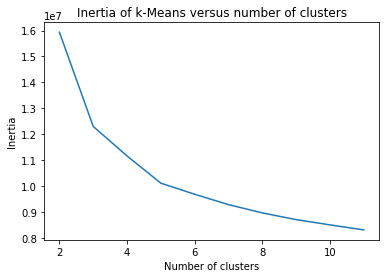

In [68]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills_4).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [69]:
# Número de clusters buscado
n_clust = 3

km = KMeans(n_clusters=n_clust)
km.fit(df_skills_4)

# Recuperacion de etiquetas
clusters = km.labels_

In [70]:
df_skills_4["cluster"] = clusters

In [71]:
df_skills_4

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                     85                   95                          70   
1                     84                   95                          90   
3                     71                   94                          85   
4                     85                   87                          62   
5                     94                   82                          55   
...                  ...                  ...                         ...   
5391                  71                   60                          50   
5392                  59                   68                          64   
5393                  59                   69                          43   
5394                  40                   51                          69   
5395                  33                   34                          55   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                          91                 88               96   
1                          82                 86               88   
3                          84                 89               85   
4                          87                 87               95   
5                          94                 82               88   
...                       ...                ...              ...   
5391                       70                 72               70   
5392                       54                 56               77   
5393                       69                 59               72   
5394                       68                 35               44   
5395                       72                 31               52   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0              93                 94                  91                  96   
1              81                 76                  77                  92   
3              79                 85                  70                  88   
4              88                 89                  81                  95   
5              85                 83                  93                  92   
...           ...                ...                 ...                 ...   
5391           70                 70                  68                  71   
5392           64                 52                  45                  78   
5393           74                 58                  65                  80   
5394           30                 23                  59                  66   
5395           34                 45                  65                  75   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                        91                     80                91   
1                        87                     91                87   
3                        77                     78                77   
4                        94                     89                96   
5                        77                     76                78   
...                     ...                    ...               ...   
5391                     71                     65                75   
5392                     88                     88                72   
5393                     71                     62                75   
5394                     54                     66                55   
5395                     50                     62                62   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                     94                95                86             68   
1                     95                71                94             95   
3                     93                82                89             84   
4                     91                83                80             62   
5                     91       

- Cantidad de observaciones por Cluster:

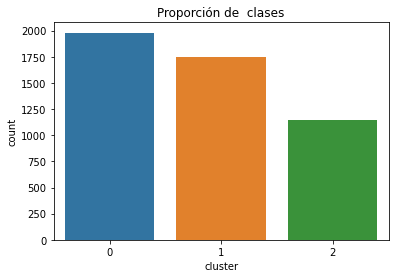

0    1980
1    1746
2    1143
Name: cluster, dtype: int64

In [72]:
sns.countplot(df_skills_4.cluster, order=df_skills_4.cluster.value_counts().index)
plt.title("Proporción de  clases")
plt.show()
df_skills_4["cluster"].value_counts()

- Analisis Descriptivo por cluster

In [73]:
df_cluster_s_0=df_skills_4[df_skills_4["cluster"]==0]
df_cluster_s_1=df_skills_4[df_skills_4["cluster"]==1]
df_cluster_s_2=df_skills_4[df_skills_4["cluster"]==2]


In [74]:
df_cluster_s_0.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1980.000000          1980.000000                 1980.000000   
mean            68.990404            58.062626                   60.878283   
std              8.078907            10.259400                   10.043505   
min             32.000000            17.000000                   22.000000   
25%             65.000000            52.000000                   55.000000   
50%             70.000000            59.000000                   61.000000   
75%             74.000000            66.000000                   68.000000   
max             94.000000            85.000000                   92.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1980.000000        1980.000000      1980.000000   
mean                 74.263131          55.928283        71.981818   
std                   5.310182          11.469929         6.028203   
min                  52.000000          21.000000        48.000000   
25%                  71.000000          48.000000        68.000000   
50%                  74.000000          56.000000        72.000000   
75%                  78.000000          64.000000        76.000000   
max                  94.000000          87.000000        92.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1980.000000        1980.000000         1980.000000         1980.000000   
mean     66.769697          59.289899           70.433333           74.030303   
std       9.778936          12.722792            6.847365            5.058535   
min      31.000000          23.000000           36.000000           50.000000   
25%      61.000000          50.000000           66.000000           71.000000   
50%      68.000000          60.000000           71.000000           74.000000   
75%      74.000000          69.000000           75.000000           77.000000   
max      92.000000          93.000000           93.000000           92.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1980.000000            1980.000000       1980.000000   
mean               70.897980              70.272222         72.232323   
std                10.042693              10.750801          8.296280   
min                31.000000              29.000000         34.000000   
25%                65.000000              64.000000         67.000000   
50%                72.000000              71.000000         73.000000   
75%                77.000000              77.000000         78.000000   
max                96.000000              96.000000         95.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1980.000000       1980.000000       1980.000000    1980.000000   
mean            72.271717         71.436869         71.040909      68.687374   
std              5.376846          9.496658          8.173080      10.795389   
min             56.000000         32.000000         28.000000      31.000000   
25%             69.000000         66.000000         66.000000      62.000000   
50%             72.000000         72.000000         72.000000      70.000000   
75%             75.000000         77.000000         77.000000      76.000000   
max             92.000000         94.000000         95.000000      93.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1980.000000     1980.000000       1980.000000           1980.000000   
mean       77.703535       68.274747         65.259091             71.741919   
std         8.506781        9.412466          9.560215              9.264218   
min        34.000000       24.000000         29.000000             30.000000   
25%        73.000000       63.000000         59.000000             67.000000   
50%        78.000000       69.000000         67.000000             72.000000   
75% 

In [75]:
df_cluster_s_1.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1746.000000          1746.000000                 1746.000000   
mean            64.633448            71.993127                   60.654066   
std             11.066701             6.375720                   13.944776   
min             23.000000            46.000000                   20.000000   
25%             60.000000            68.000000                   49.000000   
50%             67.000000            72.000000                   62.000000   
75%             72.000000            76.000000                   72.000000   
max             92.000000            95.000000                   93.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1746.000000        1746.000000      1746.000000   
mean                 70.569874          66.482818        74.905498   
std                   5.806230           8.744445         5.910770   
min                  51.000000          32.000000        57.000000   
25%                  67.000000          61.000000        71.000000   
50%                  70.000000          67.000000        75.000000   
75%                  74.000000          72.000000        79.000000   
max                  92.000000          90.000000        96.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1746.000000        1746.000000         1746.000000         1746.000000   
mean     66.870561          59.664948           60.820160           74.794960   
std      10.843739          13.874488           10.520699            5.184537   
min      21.000000          22.000000           21.000000           53.000000   
25%      61.000000          49.000000           55.000000           71.000000   
50%      68.000000          62.000000           62.000000           74.000000   
75%      74.000000          70.750000           68.000000           78.000000   
max      94.000000          94.000000           91.000000           96.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1746.000000            1746.000000       1746.000000   
mean               75.961054              75.446163         75.872852   
std                10.913816              10.382745         10.313198   
min                27.000000              30.000000         30.000000   
25%                70.000000              70.000000         70.000000   
50%                77.000000              76.000000         77.000000   
75%                84.000000              82.000000         83.000000   
max                97.000000              96.000000         96.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1746.000000       1746.000000       1746.000000    1746.000000   
mean            71.520619         71.924399         74.038946      66.549828   
std              6.017251         12.162934          6.590753      13.348882   
min             52.000000         27.000000         39.000000      28.000000   
25%             68.000000         65.000000         70.000000      58.000000   
50%             71.000000         73.000000         74.000000      68.000000   
75%             75.000000         80.000000         78.000000      76.000000   
max             95.000000         96.000000         94.000000      95.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1746.000000     1746.000000       1746.000000           1746.000000   
mean       69.613402       66.275487         68.931271             57.613402   
std         9.171153       13.306794          7.197650             13.932174   
min        30.000000       27.000000         38.000000             23.000000   
25%        65.000000       58.000000         65.000000             47.000000   
50%        70.000000       67.000000         69.000000             58.000000   
75% 

In [76]:
df_cluster_s_2.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1143.000000          1143.000000                 1143.000000   
mean            50.154856            35.707787                   70.586177   
std             14.375061             9.683449                    8.081853   
min             11.000000            12.000000                   31.000000   
25%             39.000000            29.000000                   67.000000   
50%             50.000000            35.000000                   72.000000   
75%             63.000000            42.000000                   76.000000   
max             79.000000            64.000000                   89.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1143.000000        1143.000000      1143.000000   
mean                 67.136483          35.247594        55.874891   
std                   5.954197           9.712998        10.330574   
min                  42.000000          11.000000        22.000000   
25%                  64.000000          28.000000        49.000000   
50%                  68.000000          34.000000        58.000000   
75%                  71.000000          41.000000        64.000000   
max                  83.000000          72.000000        77.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1143.000000        1143.000000         1143.000000         1143.000000   
mean     42.713036          37.542432           62.085739           63.986002   
std      11.822012          11.395289            8.234820            6.489367   
min      13.000000          10.000000           20.000000           33.000000   
25%      33.000000          30.000000           57.000000           60.000000   
50%      42.000000          35.000000           63.000000           65.000000   
75%      52.000000          44.000000           68.000000           68.500000   
max      76.000000          79.000000           84.000000           80.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1143.000000            1143.000000       1143.000000   
mean               60.213473              62.450569         57.818898   
std                12.815336              13.105625         11.981141   
min                28.000000              30.000000         26.000000   
25%                53.000000              54.000000         51.000000   
50%                62.000000              65.000000         60.000000   
75%                69.000000              72.000000         67.000000   
max                92.000000              92.000000         91.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1143.000000       1143.000000       1143.000000    1143.000000   
mean            69.629046         57.225722         56.022747      72.708661   
std              4.886157         12.274793         12.005596      11.278670   
min             53.000000         27.000000         20.000000      31.000000   
25%             67.000000         50.000000         47.000000      68.000000   
50%             69.000000         59.000000         56.000000      74.000000   
75%             73.000000         66.000000         65.000000      80.000000   
max             87.000000         89.000000         85.000000      94.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1143.000000     1143.000000       1143.000000           1143.000000   
mean       69.747157       77.402450         40.768154             74.919510   
std        10.298008        8.444154         12.911580              7.756055   
min        30.000000       31.000000         12.000000             40.000000   
25%        65.000000       73.000000         30.500000             70.500000   
50%        71.000000       78.000000         40.000000             75.000000   
75% 

En los siguientes graficos se muestra los diagramas de caja y de distribucion de cada uno de los cluster para una skills en particular. Los siguientes graficos se observa:
-  Para las varibales attacking_crossing /mentality_aggression el cluster 0 posee los puntaje mas alto.

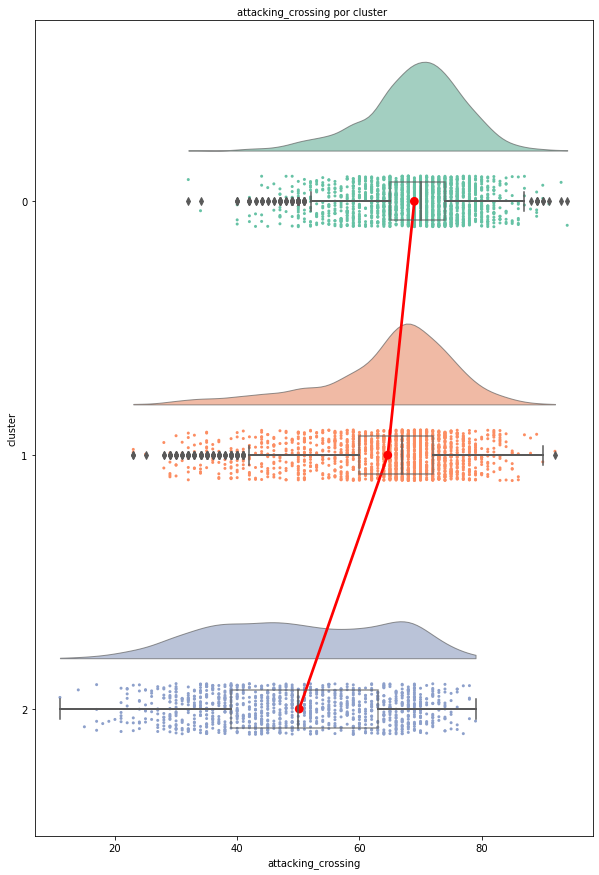

In [77]:
plt.figure(figsize=(10,15))
ax=pt.RainCloud(data=df_skills_4,y='attacking_crossing',x=df_skills_4.cluster,orient='h',pointplot = True,alpha = .65)
plt.title("attacking_crossing por cluster ",fontsize=10)
plt.show()

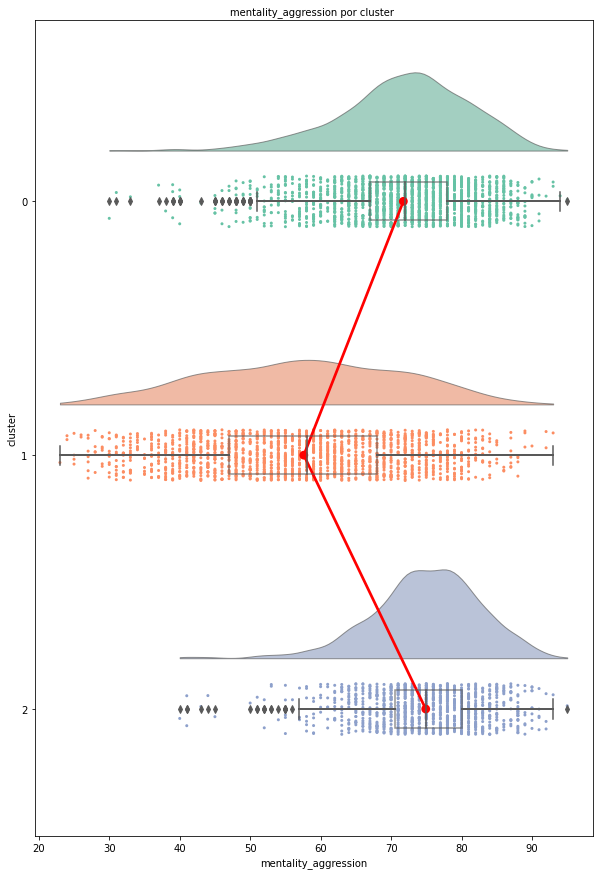

In [78]:
plt.figure(figsize=(10,15))

ax=pt.RainCloud(data=df_skills_4,y='mentality_aggression',x=df_skills_4.cluster,orient='h',pointplot = True,alpha = .65)

plt.title("mentality_aggression por cluster ",fontsize=10)
plt.show()

In [79]:
pd.crosstab(df['nationality'], df_skills_4['cluster']) 

cluster                     0    1    2
nationality                            
Albania                     3    0    4
Algeria                    11   14    0
Angola                      3    4    1
Antigua & Barbuda           0    0    1
Argentina                 133  135   89
Armenia                     1    1    0
Australia                   9    7    3
Austria                    31   20   18
Belgium                    44   36   15
Benin                       1    2    0
Bermuda                     0    1    0
Bolivia                     2    0    1
Bosnia Herzegovina         15    9    6
Brazil                    185  186  121
Bulgaria                    1    2    0
Burkina Faso                1    2    2
Burundi                     0    1    0
Cameroon                    6   10   10
Canada                      6    4    2
Cape Verde                  1    6    2
Central African Republic    1    0    1
Chad                        0    1    0
Chile                      22   16    9
China PR                    4    9    2
Colombia                   27   64   29
Comoros                     2    1    0
Congo                       1    1    1
Costa Rica                  2    1    4
Croatia                    23   17   18
Cuba                        1    0    0
Curacao                     1    0    0
Cyprus                      1    0    0
Czech Republic             34   16   12
DR Congo                    6   14    4
Denmark                    25   21   16
Dominican Republic          0    1    0
Ecuador                     8   19   13
Egypt                       8    8    2
England                   103   81   79
Equatorial Guinea           1    0    1
Eritrea                     0    1    0
Estonia                     0    0    1
Finland                     5    3    2
France                    130   99   90
Gabon                       4    2    2
Gambia                      0    3    1
Georgia                     1    3    1
Germany                   112   66   68
Ghana                      22   15   12
Greece                     15   15    7
Guinea                      4    3    1
Guinea Bissau               3    1    0
Honduras                    3    5    0
Hungary                     3    5    3
Iceland                     6    3    5
Iran                        1    6    0
Iraq                        2    0    0
Israel                      2    6    0
Italy                      70   56   49
Ivory Coast                17   17   10
Jamaica                     2    3    2
Japan                      23   26    9
Kazakhstan                  0    1    0
Kenya                       1    1    0
Korea Republic             16   14    7
Kosovo                      6    4    2
Liberia                     1    0    0
Libya                       1    1    2
Luxembourg                  1    0    2
Madagascar                  1    0    2
Malawi                      0    1    0
Mali                        9    9    7
Mexico                     46   23   21
Moldova                     1    0    1
Montenegro                  3    5    3
Montserrat                  0    1    0
Morocco                    18   17    4
Mozambique                  2    0    2
Namibia                     0    1    1
Netherlands                63   40   26
New Caledonia               0    0    1
New Zealand                 2    3    1
Nigeria                     9   29    8
North Macedonia             5    3    0
Northern Ireland            5    1    2
Norway                     26   16    6
Panama                      1    1    1
Paraguay                   13   25   15
Peru                        6    7    7
Poland                     13   16   11
Portugal                   71   58   37
Puerto Rico                 0    0    1
Republic of Ireland        16    9    6
Romania                    13   13    8
Russia                     22   13    6
Saint Kitts and Nevis       1    0    0
Saudi Arabia                6    1    0
Scotland                   24   11    4


In [80]:
pd.crosstab(df['work_rate'], df_skills_4['cluster']) 

cluster          0    1    2
work_rate                   
High/High      329  154   40
High/Low        33  232    3
High/Medium    610  624  108
Low/High        24    0  111
Low/Low          1    3    1
Low/Medium      12    2   80
Medium/High    295   28  343
Medium/Low      20  222    0
Medium/Medium  656  481  457

For n_clusters = 2 The average silhouette_score is : 0.28548315057142165
For n_clusters = 3 The average silhouette_score is : 0.2595016168600025
For n_clusters = 4 The average silhouette_score is : 0.22454472368265033
For n_clusters = 5 The average silhouette_score is : 0.1843018427376911
For n_clusters = 6 The average silhouette_score is : 0.1626989343626459


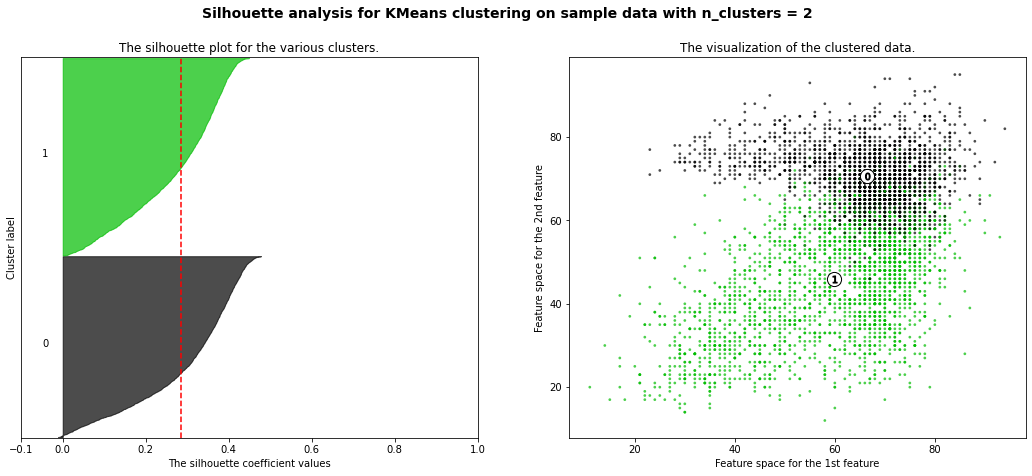

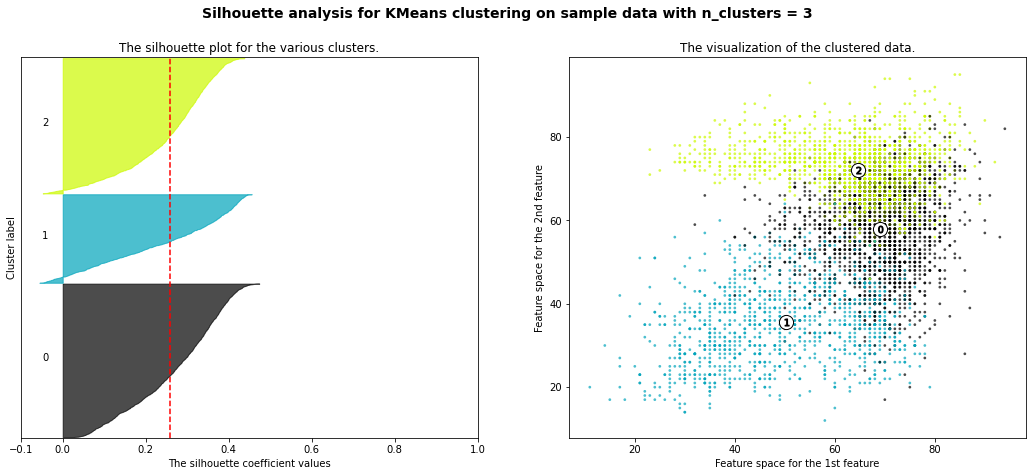

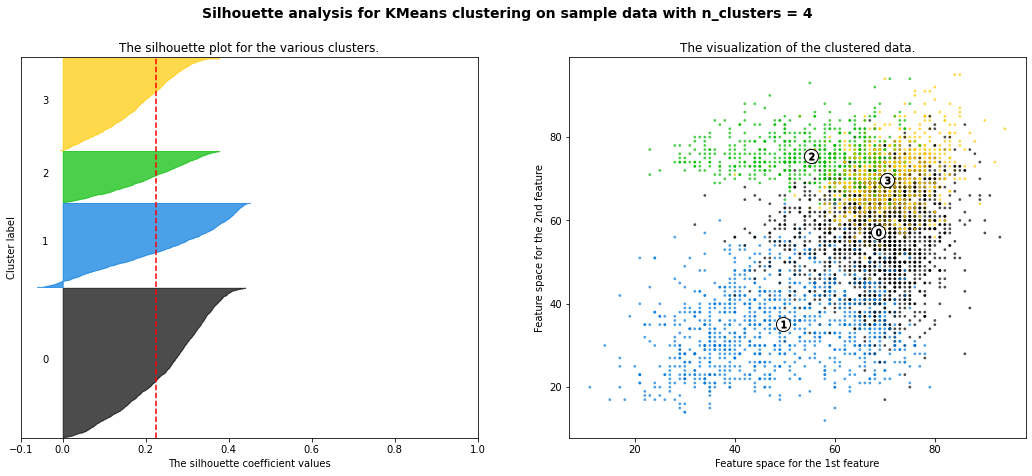

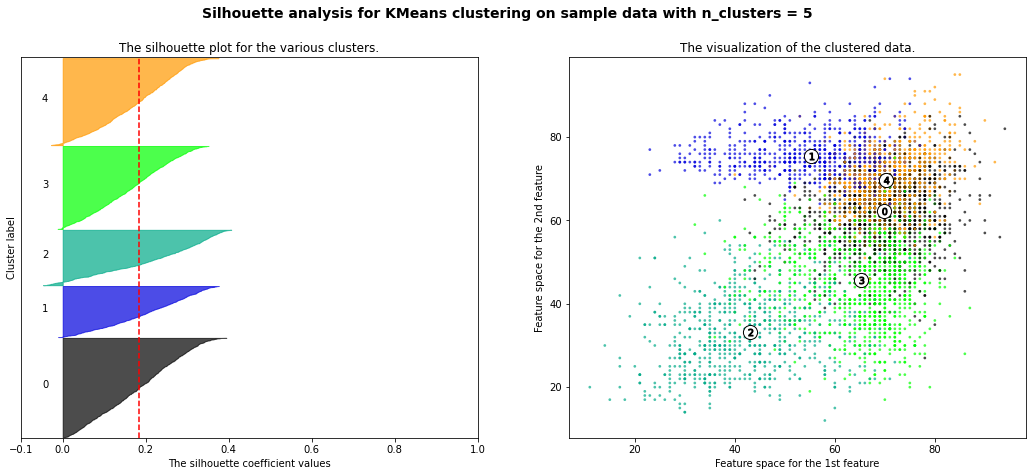

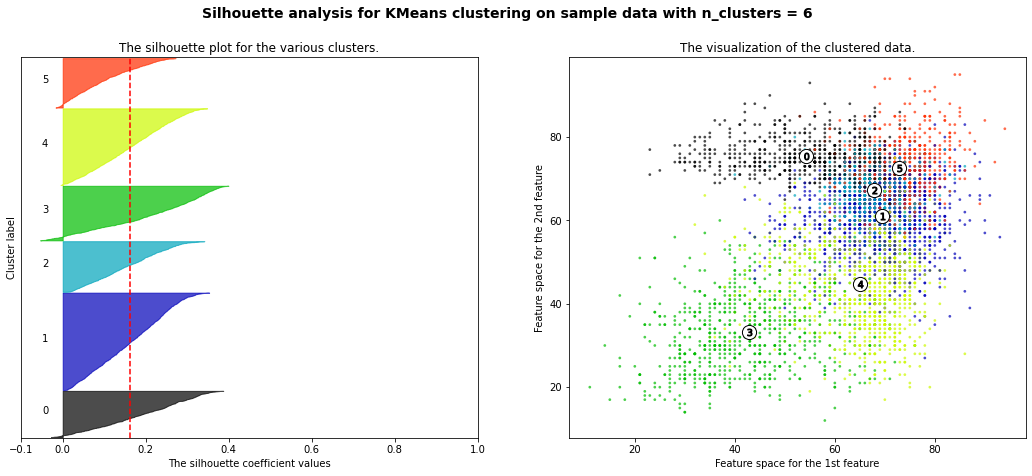

In [81]:
X=df_skills_4
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
       X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Segun los graficos y los coefientes de silhouette el numero de clustes n=5, n=4 y  n=6 no son los mejores por poca equidad de los silhoutte y el bajo valor de coeficiente.

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [82]:
df_skills_5=df_n[skills_ratings]

In [83]:
# Se probo bandwith =2,4,6. EL unico caso que nos dio un numero de cluster cercano al esperado (3) es cuando el bandwith = 6. 
#
ms = MeanShift(bandwidth=6, bin_seeding=True)

ms.fit(df_skills_5)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)

Numero de clusters encontrado por Mean Shift : 3


In [84]:
df_skills_5["cluster"] = clusters2

In [85]:
df_skills_5

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                     85                   95                          70   
1                     84                   95                          90   
3                     71                   94                          85   
4                     85                   87                          62   
5                     94                   82                          55   
...                  ...                  ...                         ...   
5391                  71                   60                          50   
5392                  59                   68                          64   
5393                  59                   69                          43   
5394                  40                   51                          69   
5395                  33                   34                          55   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                          91                 88               96   
1                          82                 86               88   
3                          84                 89               85   
4                          87                 87               95   
5                          94                 82               88   
...                       ...                ...              ...   
5391                       70                 72               70   
5392                       54                 56               77   
5393                       69                 59               72   
5394                       68                 35               44   
5395                       72                 31               52   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0              93                 94                  91                  96   
1              81                 76                  77                  92   
3              79                 85                  70                  88   
4              88                 89                  81                  95   
5              85                 83                  93                  92   
...           ...                ...                 ...                 ...   
5391           70                 70                  68                  71   
5392           64                 52                  45                  78   
5393           74                 58                  65                  80   
5394           30                 23                  59                  66   
5395           34                 45                  65                  75   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                        91                     80                91   
1                        87                     91                87   
3                        77                     78                77   
4                        94                     89                96   
5                        77                     76                78   
...                     ...                    ...               ...   
5391                     71                     65                75   
5392                     88                     88                72   
5393                     71                     62                75   
5394                     54                     66                55   
5395                     50                     62                62   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                     94                95                86             68   
1                     95                71                94             95   
3                     93                82                89             84   
4                     91                83                80             62   
5                     91       

- Cantidad de observaciones por Cluster:

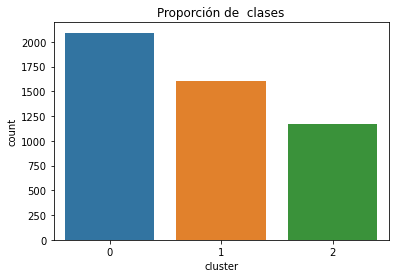

0    2093
1    1604
2    1172
Name: cluster, dtype: int64

In [86]:
sns.countplot(df_skills_5.cluster, order=df_skills_5.cluster.value_counts().index)
plt.title("Proporción de  clases")
plt.show()
df_skills_5["cluster"].value_counts()

- Analisis descriptivo por Cluster:

In [87]:
df_cluster_s_0=df_skills_5[df_skills_5["cluster"]==0]
df_cluster_s_1=df_skills_5[df_skills_5["cluster"]==1]
df_cluster_s_2=df_skills_5[df_skills_5["cluster"]==2]

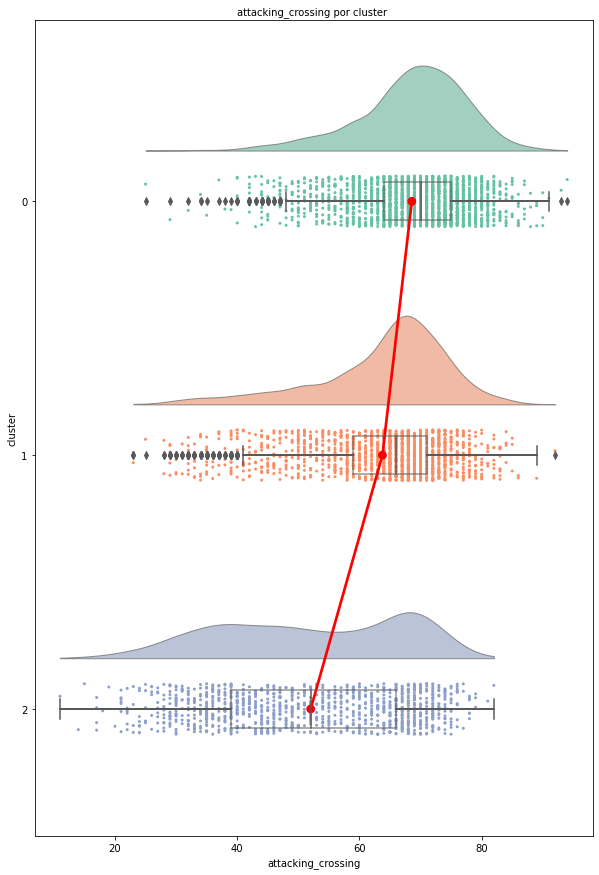

In [88]:
plt.figure(figsize=(10,15))
ax=pt.RainCloud(data=df_skills_5,y='attacking_crossing',x=df_skills_5.cluster,orient='h',pointplot = True,alpha = .65)
plt.title("attacking_crossing por cluster ",fontsize=10)
plt.show()

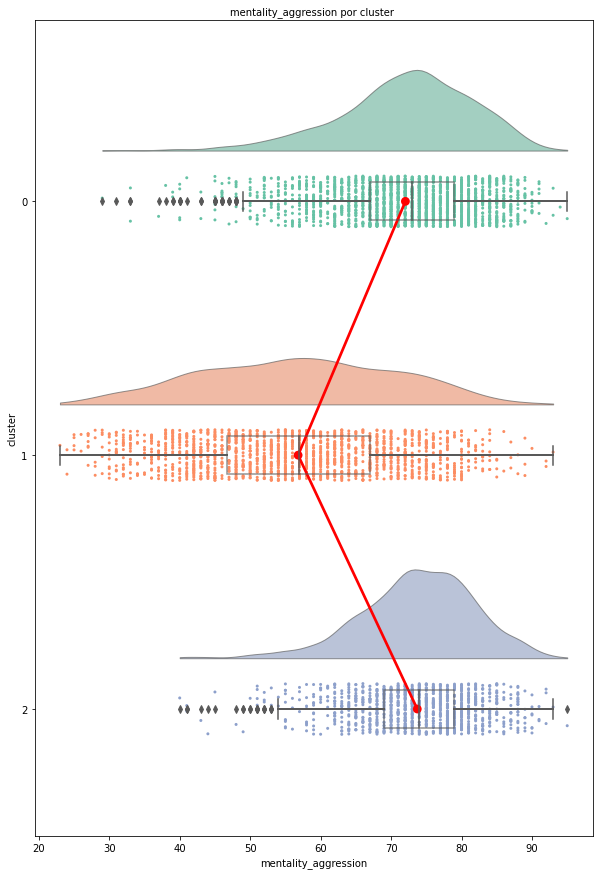

In [89]:
plt.figure(figsize=(10,15))

ax=pt.RainCloud(data=df_skills_5,y='mentality_aggression',x=df_skills_5.cluster,orient='h',pointplot = True,alpha = .65)

plt.title("mentality_aggression por cluster ",fontsize=10)
plt.show()

- Tabla de contingencia alguna categórica vs clusters

In [91]:
pd.crosstab(df['nationality'], df_skills_5['cluster']) 

cluster                     0    1    2
nationality                            
Albania                     3    0    4
Algeria                    13   12    0
Angola                      3    4    1
Antigua & Barbuda           0    0    1
Argentina                 152  122   83
Armenia                     1    1    0
Australia                   9    7    3
Austria                    34   19   16
Belgium                    45   34   16
Benin                       1    2    0
Bermuda                     0    1    0
Bolivia                     1    1    1
Bosnia Herzegovina         18    8    4
Brazil                    205  168  119
Bulgaria                    0    2    1
Burkina Faso                1    2    2
Burundi                     0    1    0
Cameroon                    8    9    9
Canada                      5    4    3
Cape Verde                  1    6    2
Central African Republic    1    0    1
Chad                        0    1    0
Chile                      23   15    9
China PR                    5    8    2
Colombia                   24   61   35
Comoros                     1    1    1
Congo                       2    1    0
Costa Rica                  2    1    4
Croatia                    25   17   16
Cuba                        1    0    0
Curacao                     1    0    0
Cyprus                      1    0    0
Czech Republic             33   14   15
DR Congo                    5   14    5
Denmark                    28   18   16
Dominican Republic          1    0    0
Ecuador                     9   18   13
Egypt                       8    8    2
England                   105   71   87
Equatorial Guinea           1    0    1
Eritrea                     0    1    0
Estonia                     0    0    1
Finland                     4    4    2
France                    142   92   85
Gabon                       4    2    2
Gambia                      0    3    1
Georgia                     1    3    1
Germany                   116   60   70
Ghana                      23   14   12
Greece                     16   13    8
Guinea                      4    3    1
Guinea Bissau               3    1    0
Honduras                    3    5    0
Hungary                     3    5    3
Iceland                     8    3    3
Iran                        1    6    0
Iraq                        2    0    0
Israel                      2    5    1
Italy                      68   56   51
Ivory Coast                18   17    9
Jamaica                     4    1    2
Japan                      22   25   11
Kazakhstan                  0    1    0
Kenya                       1    1    0
Korea Republic             17   13    7
Kosovo                      5    4    3
Liberia                     1    0    0
Libya                       1    1    2
Luxembourg                  1    0    2
Madagascar                  1    0    2
Malawi                      0    1    0
Mali                        7    9    9
Mexico                     46   23   21
Moldova                     1    0    1
Montenegro                  3    5    3
Montserrat                  0    1    0
Morocco                    17   16    6
Mozambique                  2    0    2
Namibia                     0    1    1
Netherlands                65   38   26
New Caledonia               0    0    1
New Zealand                 2    3    1
Nigeria                    10   28    8
North Macedonia             5    3    0
Northern Ireland            4    1    3
Norway                     29   15    4
Panama                      2    1    0
Paraguay                   14   24   15
Peru                        7    6    7
Poland                     18   12   10
Portugal                   78   48   40
Puerto Rico                 0    0    1
Republic of Ireland        14    9    8
Romania                    17    9    8
Russia                     17   15    9
Saint Kitts and Nevis       1    0    0
Saudi Arabia                4    1    2
Scotland                   27    8    4


In [92]:
pd.crosstab(df['work_rate'], df_skills_5['cluster']) 

cluster          0    1    2
work_rate                   
High/High      356  118   49
High/Low        39  224    5
High/Medium    597  574  171
Low/High        36    0   99
Low/Low          1    3    1
Low/Medium      12    2   80
Medium/High    333   25  308
Medium/Low      31  211    0
Medium/Medium  688  447  459

-  Coefieciente Silohuette: Si comparamos este valor obtenido con el obtenido para kmeans (The average silhouette_score is : 0.2595632894917585) ambos valores son casi iguales. Sacando los arqueros este modelo realiza un mejor clustering 
 

In [93]:
metrics.silhouette_score(df_skills_5, clusters2)


0.24533276129766426

## 7.-Clustering-Jerarquico-sin-arqueros

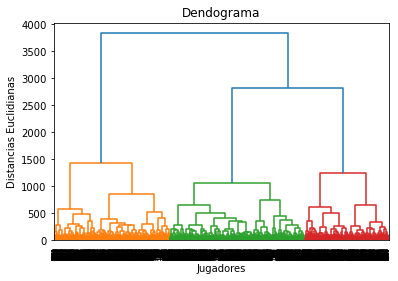

In [94]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
df_skills_6=df_n[skills_ratings]
dendrogram = sch.dendrogram(sch.linkage(df_skills_6, method = 'ward')) # Creamos el dendograma para encontrar el número óptimo de clusters
plt.title('Dendograma')
plt.xlabel('Jugadores')
plt.ylabel('Distancias Euclidianas')
plt.show()

En el endograma podemos observar que la distancia máxima la marca la línea azul oscuro que une los clusters rojo y naranja y verde claro, por lo que si realizamos el corte en esa zona obtenemos:3 clusters

In [95]:
hc = AgglomerativeClustering(n_clusters = 3, 
                    affinity = 'euclidean', 
                    linkage = 'ward')

y_hc = hc.fit_predict(X)


In [96]:
df_skills_6["cluster"] = y_hc

In [97]:
df_skills_6

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                     85                   95                          70   
1                     84                   95                          90   
3                     71                   94                          85   
4                     85                   87                          62   
5                     94                   82                          55   
...                  ...                  ...                         ...   
5391                  71                   60                          50   
5392                  59                   68                          64   
5393                  59                   69                          43   
5394                  40                   51                          69   
5395                  33                   34                          55   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                          91                 88               96   
1                          82                 86               88   
3                          84                 89               85   
4                          87                 87               95   
5                          94                 82               88   
...                       ...                ...              ...   
5391                       70                 72               70   
5392                       54                 56               77   
5393                       69                 59               72   
5394                       68                 35               44   
5395                       72                 31               52   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0              93                 94                  91                  96   
1              81                 76                  77                  92   
3              79                 85                  70                  88   
4              88                 89                  81                  95   
5              85                 83                  93                  92   
...           ...                ...                 ...                 ...   
5391           70                 70                  68                  71   
5392           64                 52                  45                  78   
5393           74                 58                  65                  80   
5394           30                 23                  59                  66   
5395           34                 45                  65                  75   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                        91                     80                91   
1                        87                     91                87   
3                        77                     78                77   
4                        94                     89                96   
5                        77                     76                78   
...                     ...                    ...               ...   
5391                     71                     65                75   
5392                     88                     88                72   
5393                     71                     62                75   
5394                     54                     66                55   
5395                     50                     62                62   

      movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                     94                95                86             68   
1                     95                71                94             95   
3                     93                82                89             84   
4                     91                83                80             62   
5                     91       

- Cantidad de observaciones por Cluster:

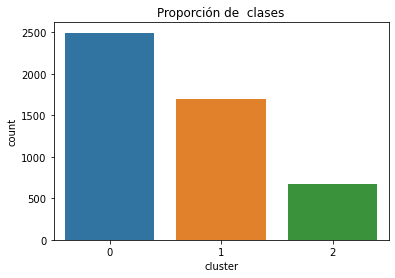

0    2496
1    1696
2     677
Name: cluster, dtype: int64

In [98]:
sns.countplot(df_skills_6.cluster, order=df_skills_6.cluster.value_counts().index)
plt.title("Proporción de  clases")
plt.show()
df_skills_6["cluster"].value_counts()

- Analisis descriptivo por Cluster:

In [99]:
df_cluster_j_0=df_skills_6[df_skills_6["cluster"]==0]
df_cluster_j_1=df_skills_6[df_skills_6["cluster"]==1]
df_cluster_j_2=df_skills_6[df_skills_6["cluster"]==2]

In [100]:
df_cluster_j_0.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         2496.000000          2496.000000                 2496.000000   
mean            67.416667            54.891426                   61.841747   
std              8.911695            12.312588                    9.992231   
min             32.000000            17.000000                   22.000000   
25%             63.000000            46.000000                   56.000000   
50%             69.000000            56.000000                   62.000000   
75%             73.000000            65.000000                   69.000000   
max             93.000000            84.000000                   92.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              2496.000000        2496.000000      2496.000000   
mean                 73.253205          52.798478        70.362580   
std                   5.468143          12.881635         6.855651   
min                  52.000000          12.000000        38.000000   
25%                  69.000000          43.000000        66.000000   
50%                  73.000000          54.000000        71.000000   
75%                  77.000000          63.000000        75.000000   
max                  93.000000          87.000000        92.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  2496.000000        2496.000000         2496.000000         2496.000000   
mean     63.579728          56.008013           69.146635           72.820913   
std      11.781377          14.186389            7.273041            5.408853   
min      21.000000          18.000000           36.000000           42.000000   
25%      56.000000          45.000000           65.000000           69.000000   
50%      65.000000          57.000000           70.000000           73.000000   
75%      72.000000          68.000000           74.000000           76.000000   
max      91.000000          93.000000           93.000000           91.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            2496.000000            2496.000000       2496.000000   
mean               70.251202              69.930288         71.003205   
std                10.346260              11.000089          8.646196   
min                30.000000              29.000000         33.000000   
25%                65.000000              64.000000         66.000000   
50%                71.000000              70.000000         71.000000   
75%                77.000000              77.000000         77.000000   
max                97.000000              96.000000         95.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         2496.000000       2496.000000       2496.000000    2496.000000   
mean            71.685497         70.196715         68.607372      69.520833   
std              5.300362          9.680350         10.116104      10.619355   
min             54.000000         31.000000         24.000000      31.000000   
25%             68.000000         65.000000         63.000000      63.000000   
50%             71.000000         71.000000         70.000000      71.000000   
75%             75.000000         76.000000         75.000000      77.000000   
max             92.000000         94.000000         95.000000      94.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    2496.000000     2496.000000       2496.000000           2496.000000   
mean       76.828526       69.126603         61.880208             71.840946   
std         8.865972        9.221392         12.145794              9.325593   
min        32.000000       24.000000         21.000000             30.000000   
25%        72.000000       64.000000         55.000000             66.000000   
50%        77.000000       70.000000         64.000000             73.000000   
75% 

In [101]:
df_cluster_j_1.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count         1696.000000          1696.000000                 1696.000000   
mean            64.605542            72.080778                   60.683373   
std             11.247684             6.468619                   14.127004   
min             23.000000            46.000000                   20.000000   
25%             60.000000            68.000000                   49.000000   
50%             67.000000            72.000000                   62.000000   
75%             72.000000            76.000000                   72.000000   
max             94.000000            95.000000                   93.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count              1696.000000        1696.000000      1696.000000   
mean                 70.634434          66.637972        74.994693   
std                   5.936406           8.830014         6.018798   
min                  51.000000          32.000000        57.000000   
25%                  67.000000          61.000000        71.000000   
50%                  70.000000          67.000000        75.000000   
75%                  74.000000          73.000000        79.000000   
max                  94.000000          90.000000        96.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count  1696.000000        1696.000000         1696.000000         1696.000000   
mean     66.919811          59.626769           60.758255           74.885024   
std      10.924279          13.901990           10.684118            5.311233   
min      21.000000          22.000000           21.000000           53.000000   
25%      60.000000          49.000000           54.000000           71.000000   
50%      68.000000          62.000000           62.000000           74.000000   
75%      74.250000          70.000000           68.000000           78.000000   
max      94.000000          94.000000           93.000000           96.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count            1696.000000            1696.000000       1696.000000   
mean               76.113797              75.603774         75.982311   
std                10.715661              10.087339         10.319711   
min                27.000000              30.000000         30.000000   
25%                71.000000              70.000000         71.000000   
50%                77.000000              76.000000         77.000000   
75%                84.000000              82.000000         83.000000   
max                96.000000              96.000000         96.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count         1696.000000       1696.000000       1696.000000    1696.000000   
mean            71.619104         72.092571         74.126179      66.504717   
std              6.136113         12.216302          6.692355      13.432140   
min             52.000000         27.000000         39.000000      28.000000   
25%             68.000000         65.000000         70.000000      58.000000   
50%             71.000000         74.000000         74.000000      68.000000   
75%             75.000000         80.000000         78.000000      76.000000   
max             95.000000         96.000000         94.000000      95.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count    1696.000000     1696.000000       1696.000000           1696.000000   
mean       69.771226       66.097877         68.919811             57.528302   
std         8.984655       13.581824          7.374479             14.051877   
min        30.000000       27.000000         38.000000             23.000000   
25%        65.000000       58.000000         65.000000             47.000000   
50%        70.000000       67.000000         69.000000             58.000000   
75% 

In [102]:
df_cluster_j_2.describe()

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
count          677.000000           677.000000                  677.000000   
mean            42.740030            32.821270                   73.626292   
std             12.140587             9.220136                    5.647753   
min             11.000000            12.000000                   31.000000   
25%             34.000000            26.000000                   71.000000   
50%             41.000000            32.000000                   74.000000   
75%             51.000000            39.000000                   77.000000   
max             77.000000            60.000000                   89.000000   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
count               677.000000         677.000000       677.000000   
mean                 65.519941          32.942393        50.750369   
std                   6.204238           9.579838         9.454877   
min                  42.000000          11.000000        22.000000   
25%                  62.000000          26.000000        45.000000   
50%                  66.000000          32.000000        51.000000   
75%                  70.000000          39.000000        58.000000   
max                  80.000000          62.000000        70.000000   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
count   677.000000         677.000000          677.000000          677.000000   
mean     37.799114          34.796160           60.528804           61.361891   
std      10.413825          11.042272            8.566542            6.392527   
min      13.000000          10.000000           20.000000           33.000000   
25%      30.000000          27.000000           56.000000           57.000000   
50%      36.000000          32.000000           62.000000           62.000000   
75%      45.000000          40.000000           67.000000           66.000000   
max      76.000000          79.000000           80.000000           80.000000   

       movement_acceleration  movement_sprint_speed  movement_agility  \
count             677.000000             677.000000        677.000000   
mean               55.234860              58.314623         52.423929   
std                11.870707              12.755321         11.282634   
min                28.000000              30.000000         26.000000   
25%                48.000000              51.000000         45.000000   
50%                57.000000              60.000000         54.000000   
75%                64.000000              68.000000         61.000000   
max                83.000000              88.000000         77.000000   

       movement_reactions  movement_balance  power_shot_power  power_jumping  \
count          677.000000        677.000000        677.000000     677.000000   
mean            69.669129         51.630724         54.660266      72.358936   
std              4.947638         11.083310         12.299508      12.592485   
min             53.000000         27.000000         20.000000      31.000000   
25%             67.000000         43.000000         45.000000      68.000000   
50%             69.000000         53.000000         55.000000      75.000000   
75%             73.000000         60.000000         64.000000      80.000000   
max             85.000000         81.000000         85.000000      94.000000   

       power_stamina  power_strength  power_long_shots  mentality_aggression  \
count     677.000000      677.000000        677.000000            677.000000   
mean       66.503693       80.841950         36.667651             75.911374   
std        10.264926        6.243824         12.515566              6.797002   
min        30.000000       51.000000         12.000000             40.000000   
25%        62.000000       77.000000         27.000000             72.000000   
50%        68.000000       80.000000         35.000000             76.000000   
75% 

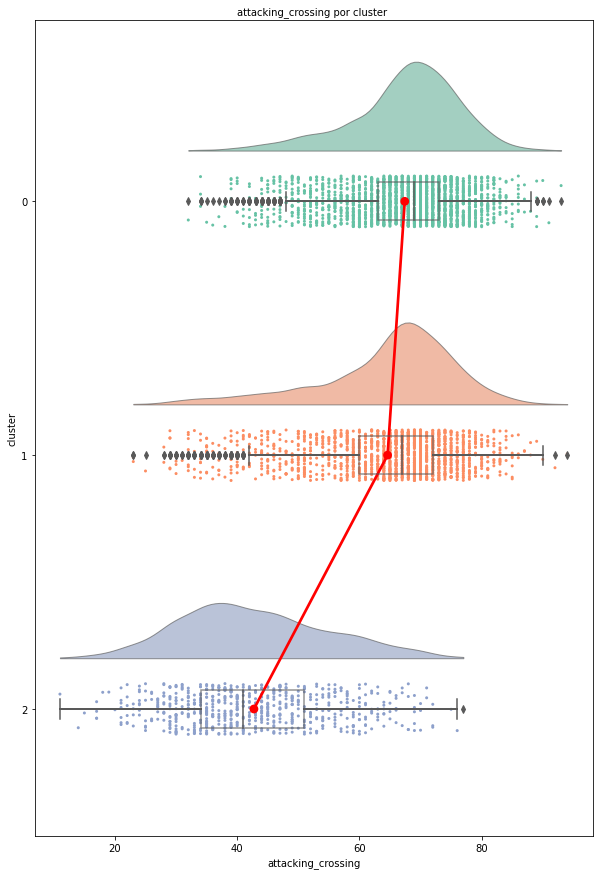

In [103]:
plt.figure(figsize=(10,15))
ax=pt.RainCloud(data=df_skills_6,y='attacking_crossing',x=df_skills_6.cluster,orient='h',pointplot = True,alpha = .65)
plt.title("attacking_crossing por cluster ",fontsize=10)
plt.show()

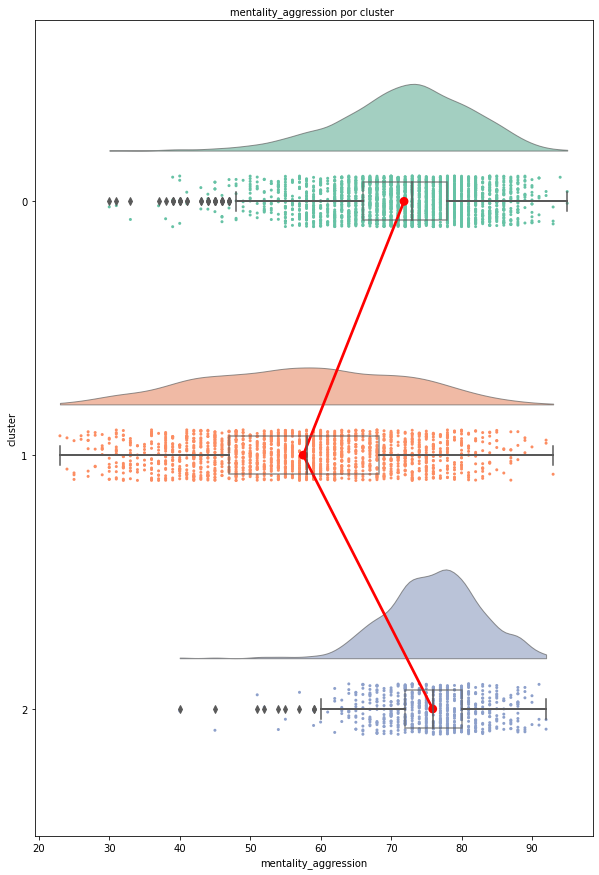

In [104]:
plt.figure(figsize=(10,15))

ax=pt.RainCloud(data=df_skills_6,y='mentality_aggression',x=df_skills_6.cluster,orient='h',pointplot = True,alpha = .65)

plt.title("mentality_aggression por cluster ",fontsize=10)
plt.show()

- Tabla de contingencia alguna categórica vs clusters

In [107]:
pd.crosstab(df['nationality'], df_skills_6['cluster']) 

cluster                     0    1   2
nationality                           
Albania                     4    0   3
Algeria                    12   13   0
Angola                      3    4   1
Antigua & Barbuda           1    0   0
Argentina                 175  131  51
Armenia                     0    2   0
Australia                  11    7   1
Austria                    42   19   8
Belgium                    49   35  11
Benin                       1    2   0
Bermuda                     0    1   0
Bolivia                     3    0   0
Bosnia Herzegovina         15   10   5
Brazil                    239  179  74
Bulgaria                    1    2   0
Burkina Faso                2    2   1
Burundi                     0    1   0
Cameroon                   13    9   4
Canada                      7    4   1
Cape Verde                  1    6   2
Central African Republic    1    0   1
Chad                        0    1   0
Chile                      30   13   4
China PR                    7    8   0
Colombia                   43   58  19
Comoros                     2    1   0
Congo                       2    1   0
Costa Rica                  3    1   3
Croatia                    27   19  12
Cuba                        1    0   0
Curacao                     1    0   0
Cyprus                      1    0   0
Czech Republic             42   14   6
DR Congo                    6   14   4
Denmark                    33   19  10
Dominican Republic          0    1   0
Ecuador                    15   18   7
Egypt                       7    9   2
England                   132   80  51
Equatorial Guinea           2    0   0
Eritrea                     0    1   0
Estonia                     0    0   1
Finland                     6    3   1
France                    174   99  46
Gabon                       5    2   1
Gambia                      0    3   1
Georgia                     1    3   1
Germany                   144   65  37
Ghana                      26   16   7
Greece                     17   14   6
Guinea                      4    3   1
Guinea Bissau               3    1   0
Honduras                    3    5   0
Hungary                     5    5   1
Iceland                     8    3   3
Iran                        1    6   0
Iraq                        2    0   0
Israel                      2    6   0
Italy                      84   57  34
Ivory Coast                20   17   7
Jamaica                     4    1   2
Japan                      26   25   7
Kazakhstan                  0    1   0
Kenya                       1    1   0
Korea Republic             23    9   5
Kosovo                      7    4   1
Liberia                     1    0   0
Libya                       2    1   1
Luxembourg                  1    0   2
Madagascar                  3    0   0
Malawi                      0    1   0
Mali                       14    9   2
Mexico                     62   22   6
Moldova                     1    0   1
Montenegro                  5    5   1
Montserrat                  0    1   0
Morocco                    19   18   2
Mozambique                  4    0   0
Namibia                     1    1   0
Netherlands                77   39  13
New Caledonia               0    0   1
New Zealand                 2    3   1
Nigeria                    12   28   6
North Macedonia             5    3   0
Northern Ireland            5    1   2
Norway                     27   17   4
Panama                      2    1   0
Paraguay                   16   26  11
Peru                        8    7   5
Poland                     21   15   4
Portugal                   83   58  25
Puerto Rico                 1    0   0
Republic of Ireland        17    9   5
Romania                    19   11   4
Russia                     22   15   4
Saint Kitts and Nevis       1    0   0
Saudi Arabia                6    1   0
Scotland                   25   10   4
Senegal                    11   19   8
Serbia                     24   16  13
Sierra Leone          

In [108]:
pd.crosstab(df['work_rate'], df_skills_6['cluster']) 

cluster          0    1    2
work_rate                   
High/High      360  152   11
High/Low        46  221    1
High/Medium    702  612   28
Low/High        56    0   79
Low/Low          1    3    1
Low/Medium      20    2   72
Medium/High    415   29  222
Medium/Low      33  209    0
Medium/Medium  863  468  263

-  Coefieciente Silohuette: Si comparamos este valor obtenido con el obtenido para kmeans/meanshift ambos valores son casi iguales. Sacando los arqueros este modelo realiza un mejor clustering 

In [109]:
metrics.silhouette_score(df_skills_6, y_hc)

0.25735859949469425